## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.0
Keras version: 3.4.1
GPU devices: 1


In [2]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


## ⏳ Load the Data (no outlier)

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

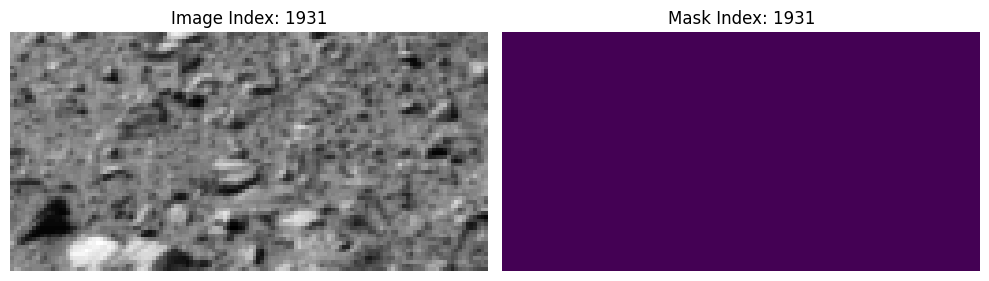

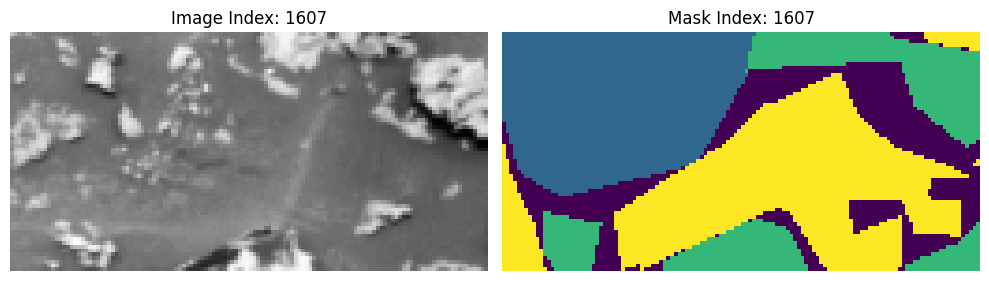

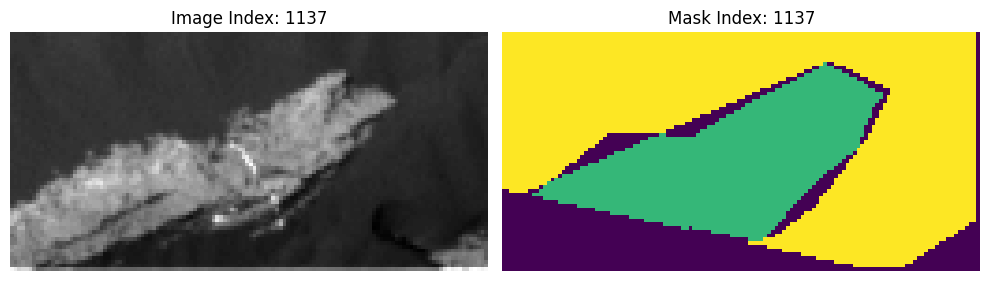

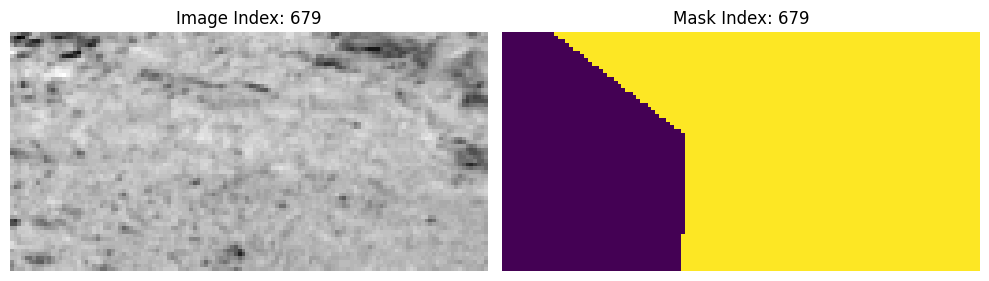

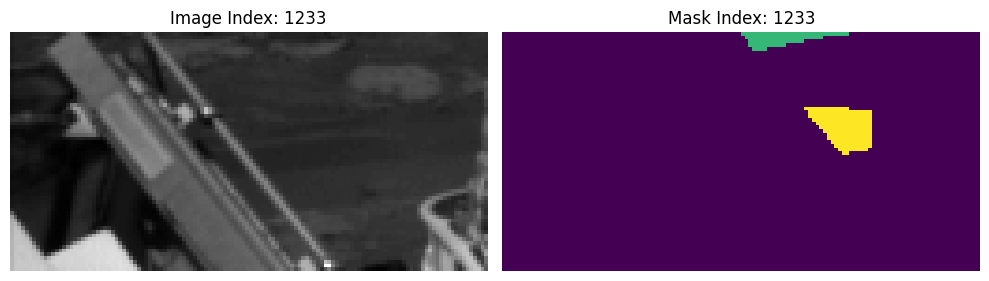

In [4]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

### rotation

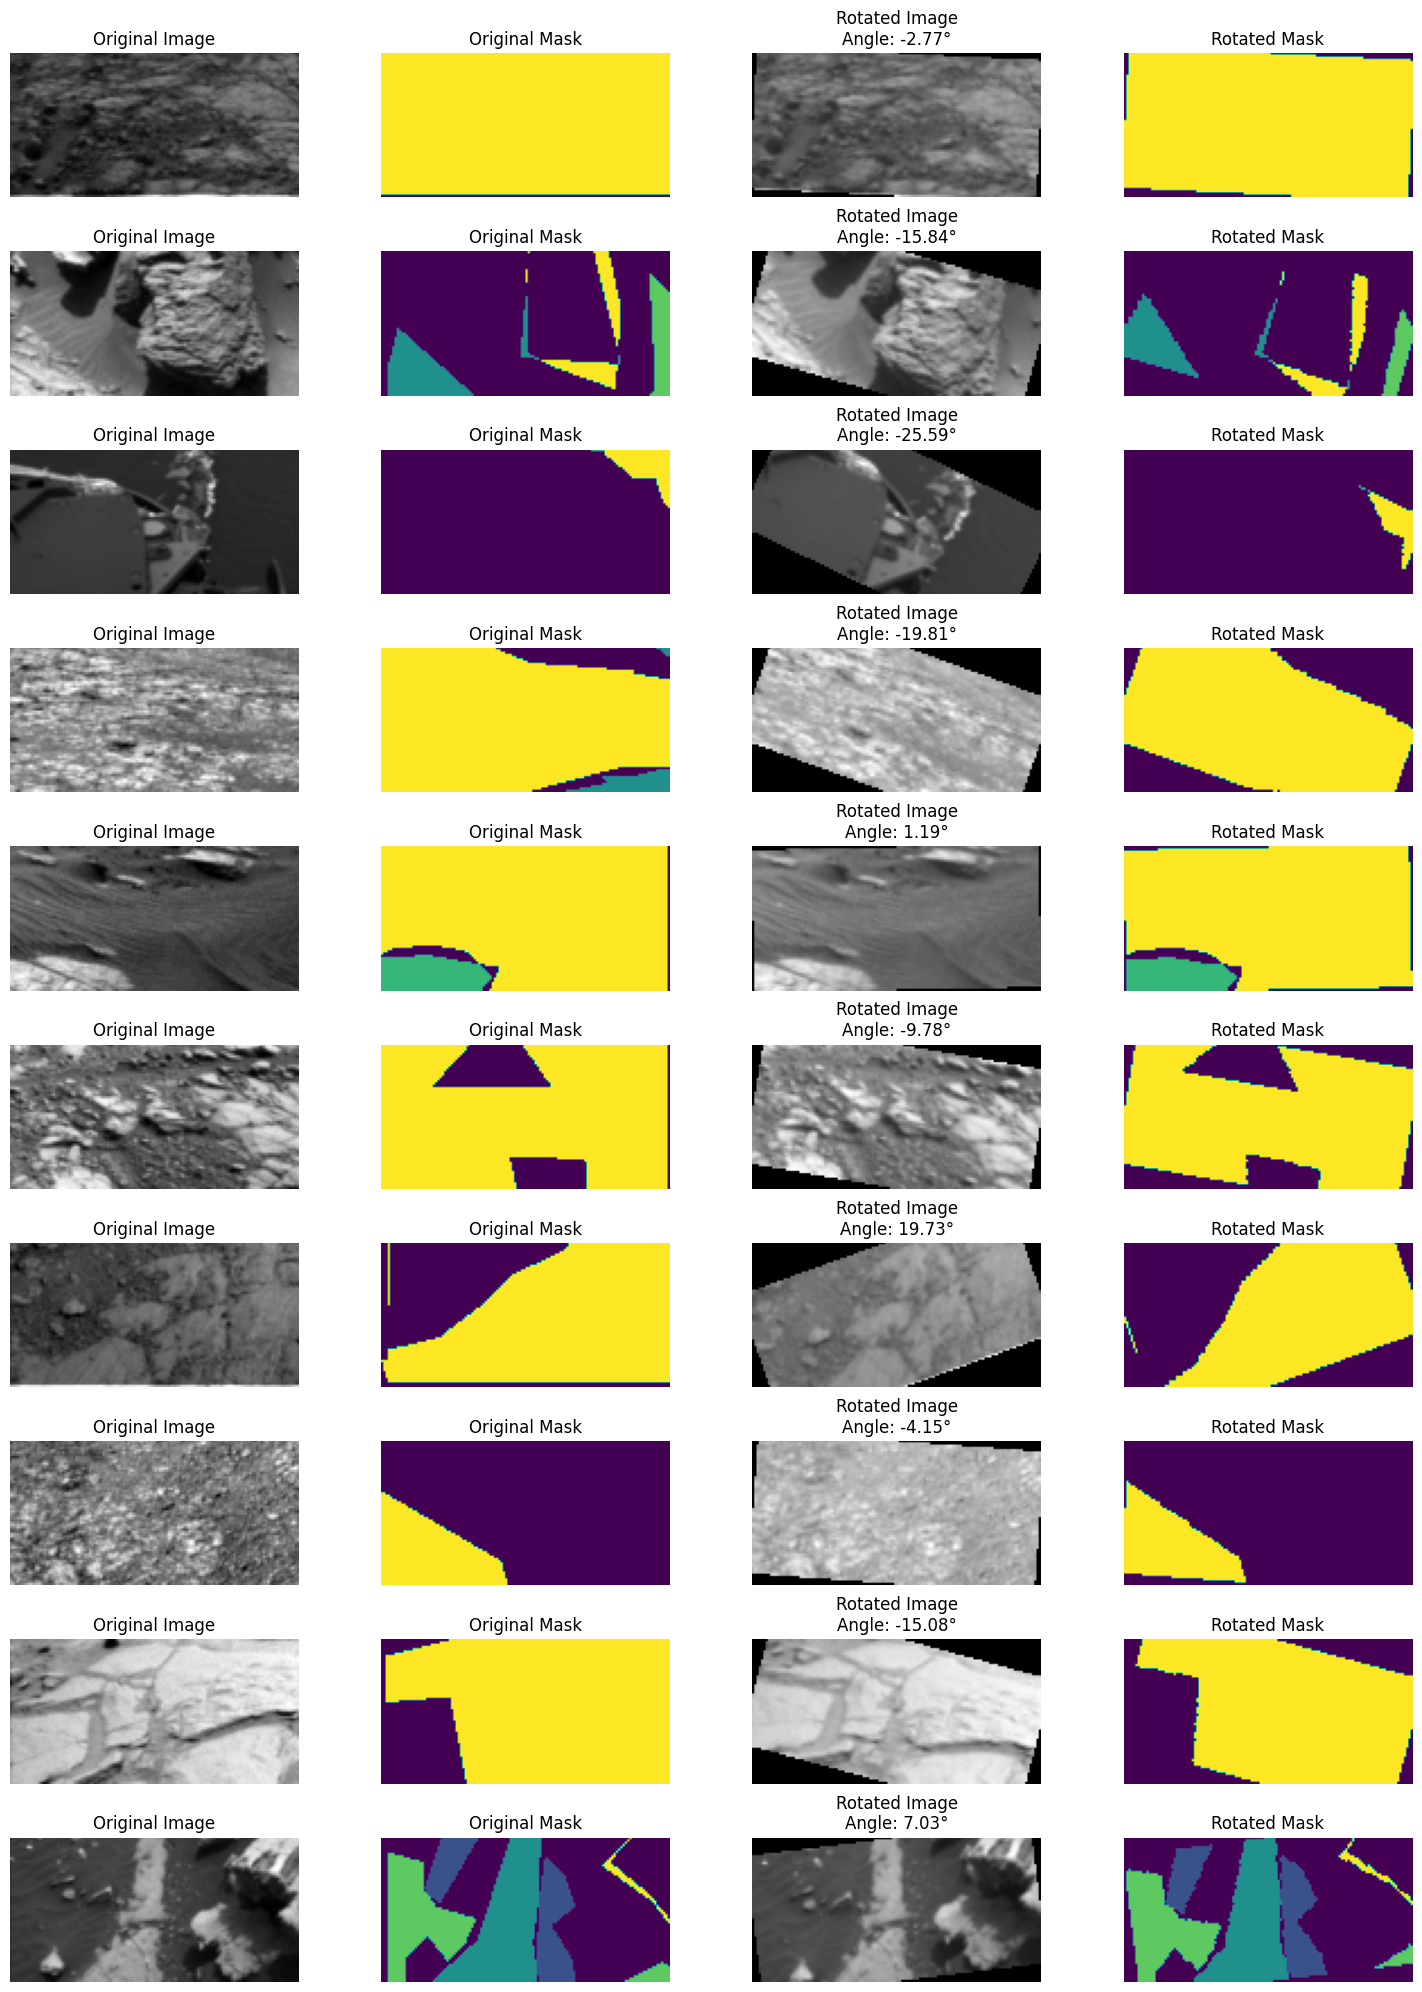

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define the rotation function using scipy
def rotate_image_and_mask(image, mask, angle):
    """
    Rotate a grayscale image and its corresponding mask by a given angle.
    """
    # Rotate the grayscale image (bilinear interpolation)
    rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

    # Rotate the mask (nearest-neighbor interpolation)
    rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

    return rotated_image, rotated_mask

# Randomly select 10 images
random_indices = np.random.choice(len(X_train), size=10, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply random rotation and visualize
plt.figure(figsize=(15, 20))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Generate a random angle for rotation
    angle = np.random.uniform(-30, 30)  # Random angle between -30° and 30°

    # Rotate the image and mask
    rotated_image, rotated_mask = rotate_image_and_mask(image, mask, angle)

    # Plot original and rotated images/masks
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Rotated Image\nAngle: {angle:.2f}°")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(rotated_mask, cmap="viridis")
    plt.title("Rotated Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


## random

In [14]:
def random_crop(image, mask, crop_size=(48, 96)):
    crop_height, crop_width = crop_size
    original_height, original_width = image.shape[:2]

    # Randomly select crop start points
    top = np.random.randint(0, original_height - crop_height + 1)
    left = np.random.randint(0, original_width - crop_width + 1)

    # Crop the image and mask
    cropped_image = image[top:top + crop_height, left:left + crop_width]
    cropped_mask = mask[top:top + crop_height, left:left + crop_width]

    # Add channel dimension if missing for tf.image.resize
    cropped_image = cropped_image[..., np.newaxis]  # Add channel dimension
    cropped_mask = cropped_mask[..., np.newaxis]  # Add channel dimension

    # Resize back to original size
    resized_image = tf.image.resize(cropped_image, (original_height, original_width), method="bilinear").numpy()
    resized_mask = tf.image.resize(cropped_mask, (original_height, original_width), method="nearest").numpy()

    # Remove channel dimension for consistency
    resized_image = resized_image.squeeze()
    resized_mask = resized_mask.squeeze()

    return resized_image, resized_mask

In [10]:
def random_flip(image, mask):
    # Random horizontal flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)

    # Random vertical flip
    if np.random.rand() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)

    return image, mask


In [20]:
def random_scale(image, mask, scale_range=(0.8, 1.2)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    original_height, original_width = image.shape[:2]

    # Scale the image and mask
    scaled_height = int(original_height * scale_factor)
    scaled_width = int(original_width * scale_factor)

    # Add a channel dimension before resizing
    image = image[..., np.newaxis]
    mask = mask[..., np.newaxis]

    scaled_image = tf.image.resize(image, (scaled_height, scaled_width), method="bilinear").numpy()
    scaled_mask = tf.image.resize(mask, (scaled_height, scaled_width), method="nearest").numpy()

    # Crop or pad to the original size
    scaled_image = tf.image.resize(scaled_image, (original_height, original_width), method="bilinear").numpy()
    scaled_mask = tf.image.resize(scaled_mask, (original_height, original_width), method="nearest").numpy()

    # Remove the channel dimension after resizing if necessary
    scaled_image = scaled_image.squeeze()
    scaled_mask = scaled_mask.squeeze()

    return scaled_image, scaled_mask

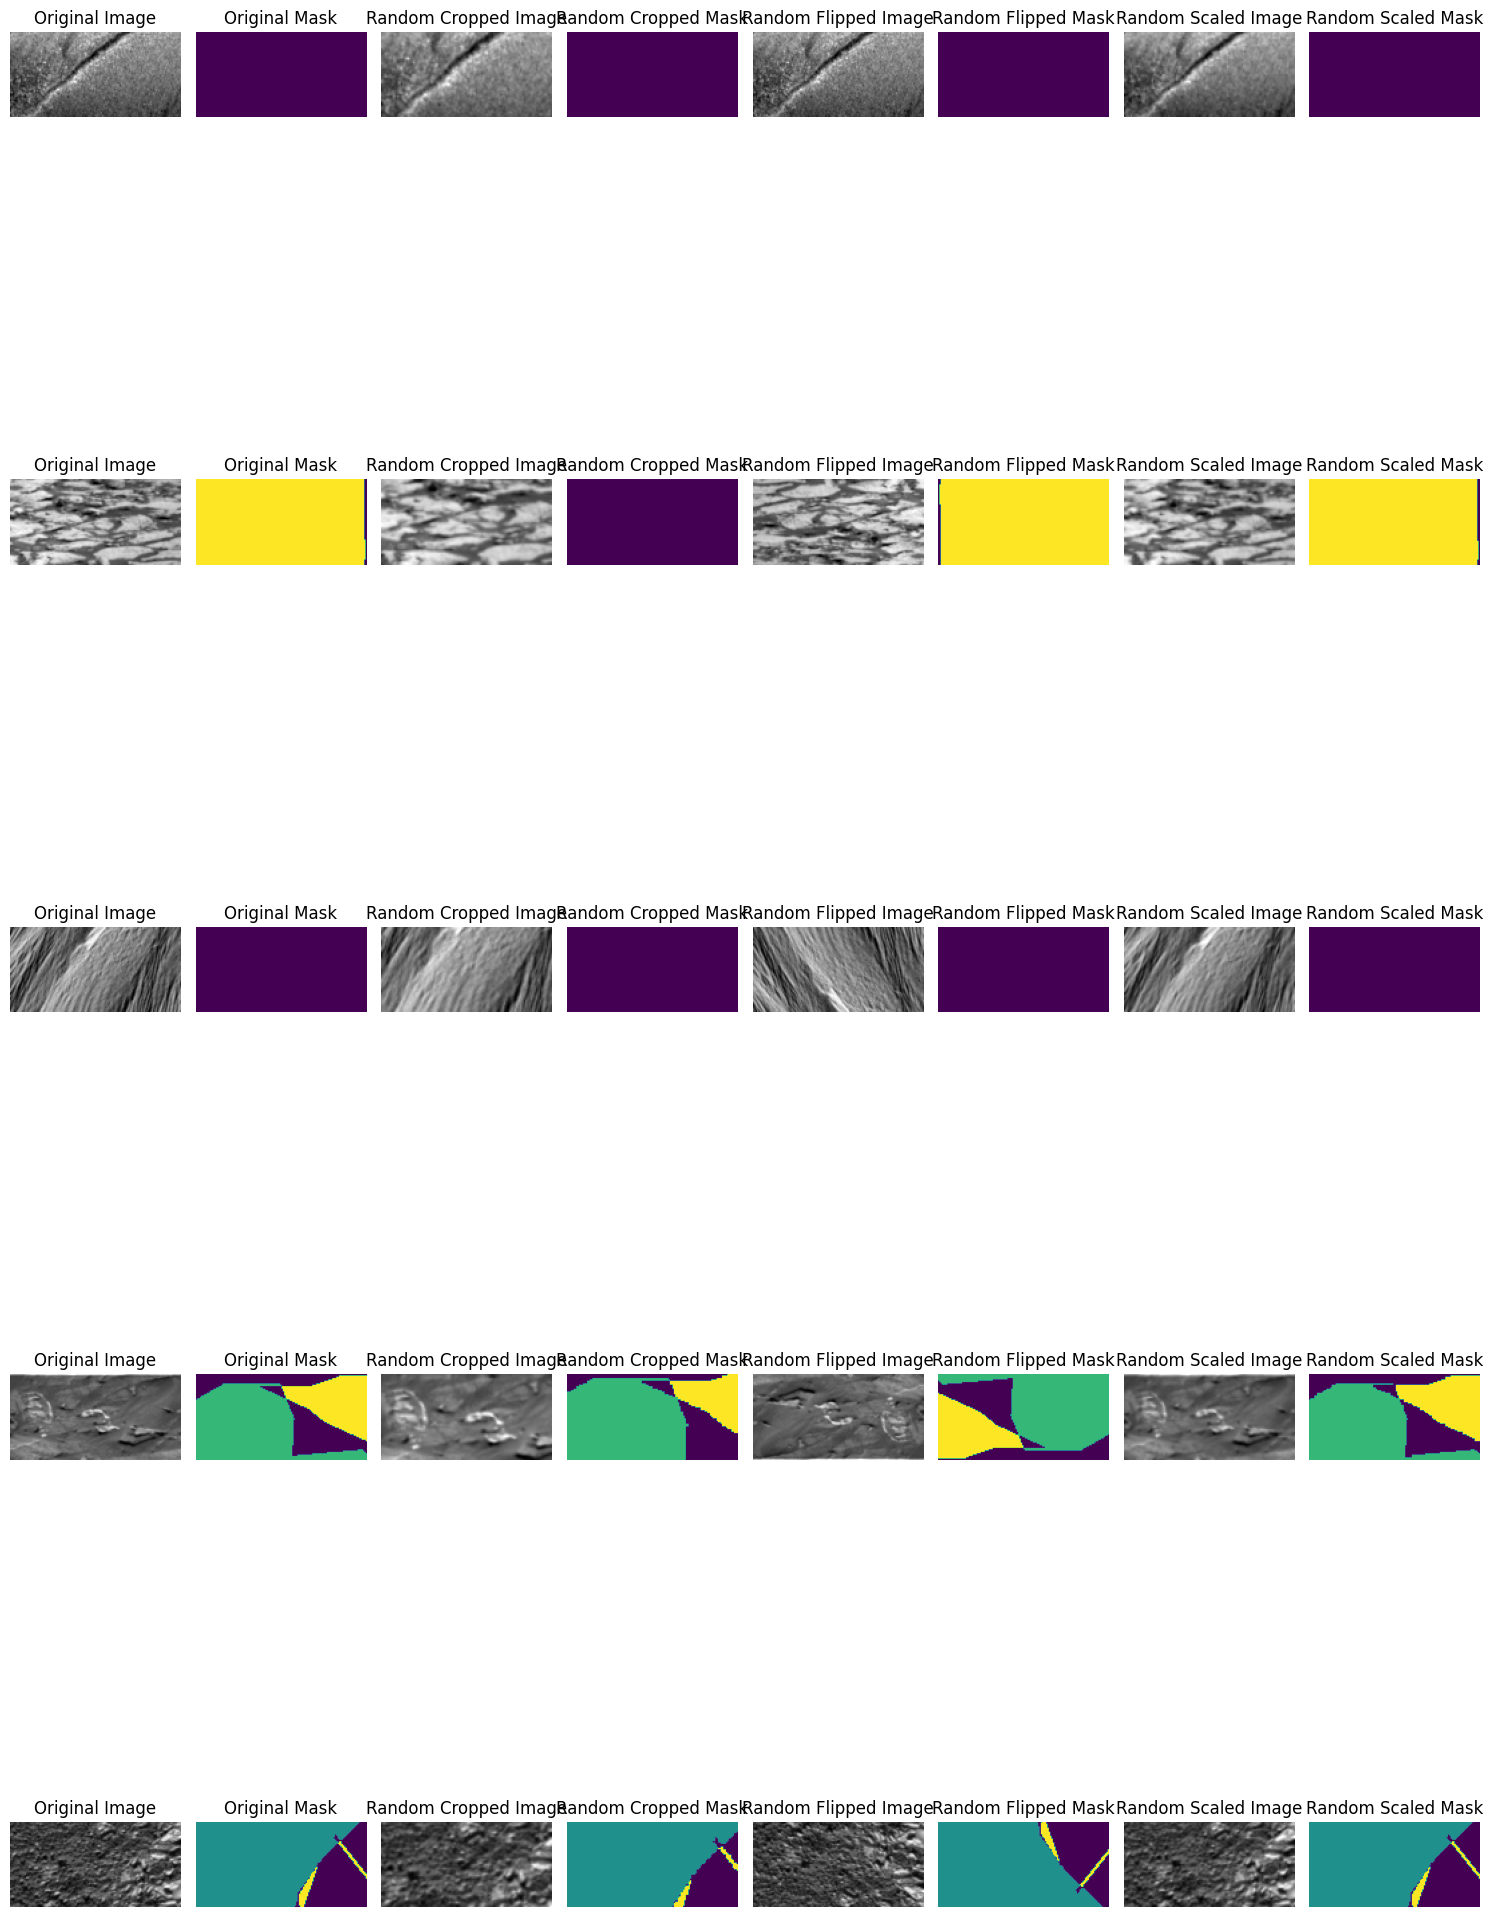

In [25]:
# Randomly select 5 samples from the dataset
random_indices = np.random.choice(len(X_train), size=5, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply augmentations
plt.figure(figsize=(15, 25))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Original
    plt.subplot(5, 8, i * 8 + 1)  # Adjusted subplot index
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(5, 8, i * 8 + 2)  # Adjusted subplot index
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    # Apply Random Crop
    cropped_image, cropped_mask = random_crop(image, mask)
    plt.subplot(5, 8, i * 8 + 3)  # Adjusted subplot index
    plt.imshow(cropped_image, cmap="gray")
    plt.title("Random Cropped Image")
    plt.axis("off")

    plt.subplot(5, 8, i * 8 + 4)  # Adjusted subplot index
    plt.imshow(cropped_mask, cmap="viridis")
    plt.title("Random Cropped Mask")
    plt.axis("off")

    # Apply Random Flip
    flipped_image, flipped_mask = random_flip(image, mask)
    plt.subplot(5, 8, i * 8 + 5)  # Adjusted subplot index
    plt.imshow(flipped_image, cmap="gray")
    plt.title("Random Flipped Image")
    plt.axis("off")

    plt.subplot(5, 8, i * 8 + 6)  # Adjusted subplot index
    plt.imshow(flipped_mask, cmap="viridis")
    plt.title("Random Flipped Mask")
    plt.axis("off")

    # Apply Random Scale
    scaled_image, scaled_mask = random_scale(image, mask)
    plt.subplot(5, 8, i * 8 + 7)  # Adjusted subplot index
    plt.imshow(scaled_image, cmap="gray")
    plt.title("Random Scaled Image")
    plt.axis("off")

    plt.subplot(5, 8, i * 8 + 8)  # Adjusted subplot index
    plt.imshow(scaled_mask, cmap="viridis")
    plt.title("Random Scaled Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


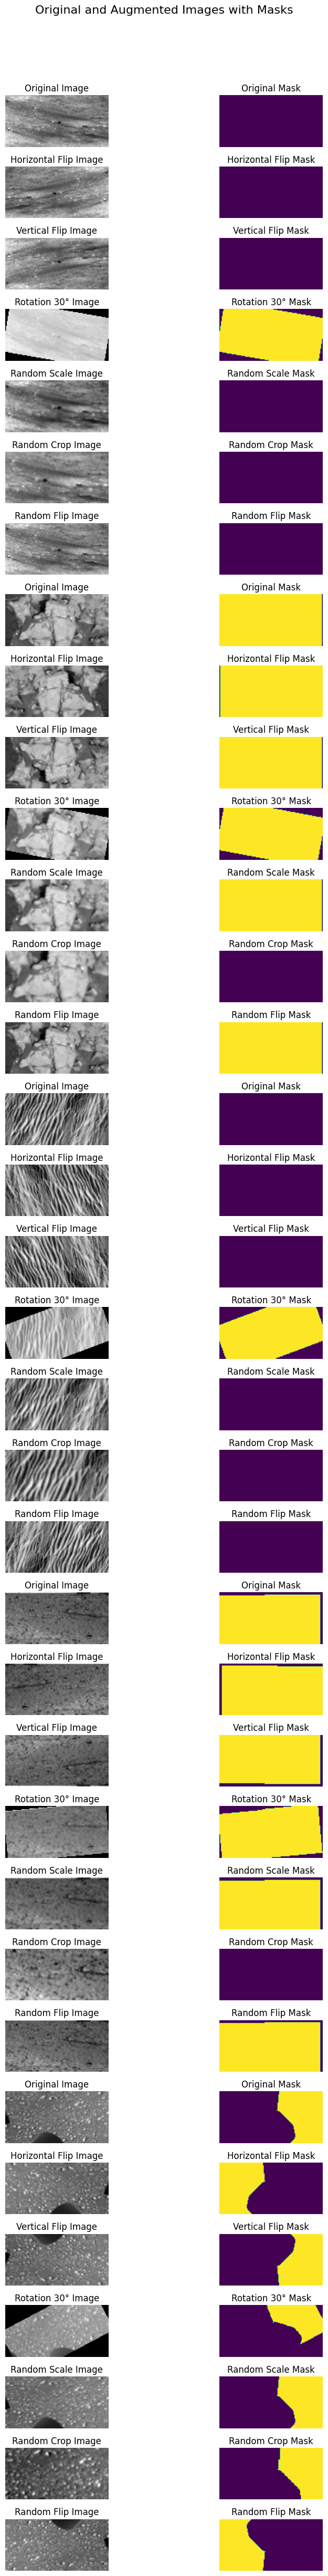

In [27]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    elif augment_type == "Rotation 30°":
        angle = np.random.uniform(-30, 30)
        # Rotate the grayscale image (bilinear interpolation)
        rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

        # Rotate the mask (nearest-neighbor interpolation)
        rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

        return rotated_image, rotated_mask
    elif augment_type == "Random Scale":
        scaled_image, scaled_mask = random_scale(image, mask)
        return scaled_image, scaled_mask
    elif augment_type == "Random Crop":
        cropped_image, cropped_mask = random_crop(image, mask)
        return cropped_image, cropped_mask
    elif augment_type == "Random Flip":
        flipped_image, flipped_mask = random_flip(image, mask)
        return flipped_image, flipped_mask
    """elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    "Rotation 30°": "Rotation 30°",
    "Random Scale":"Random Scale",
    "Random Crop":"Random Crop",
    "Random Flip":"Random Flip",
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [28]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_train, y_train):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


File: horizontal_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


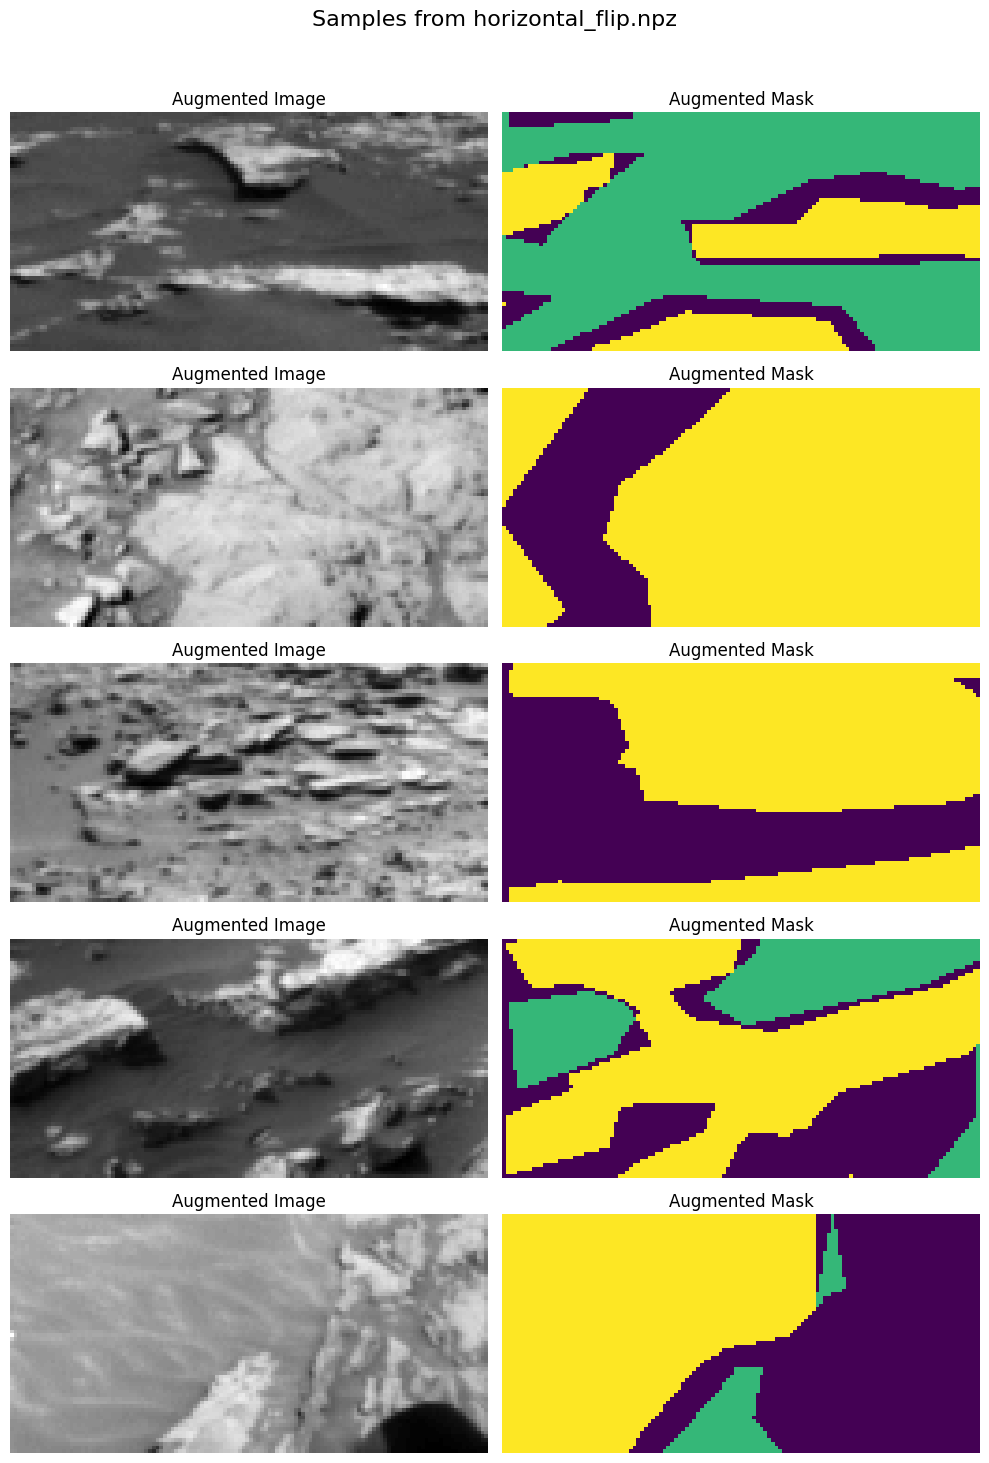

File: vertical_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


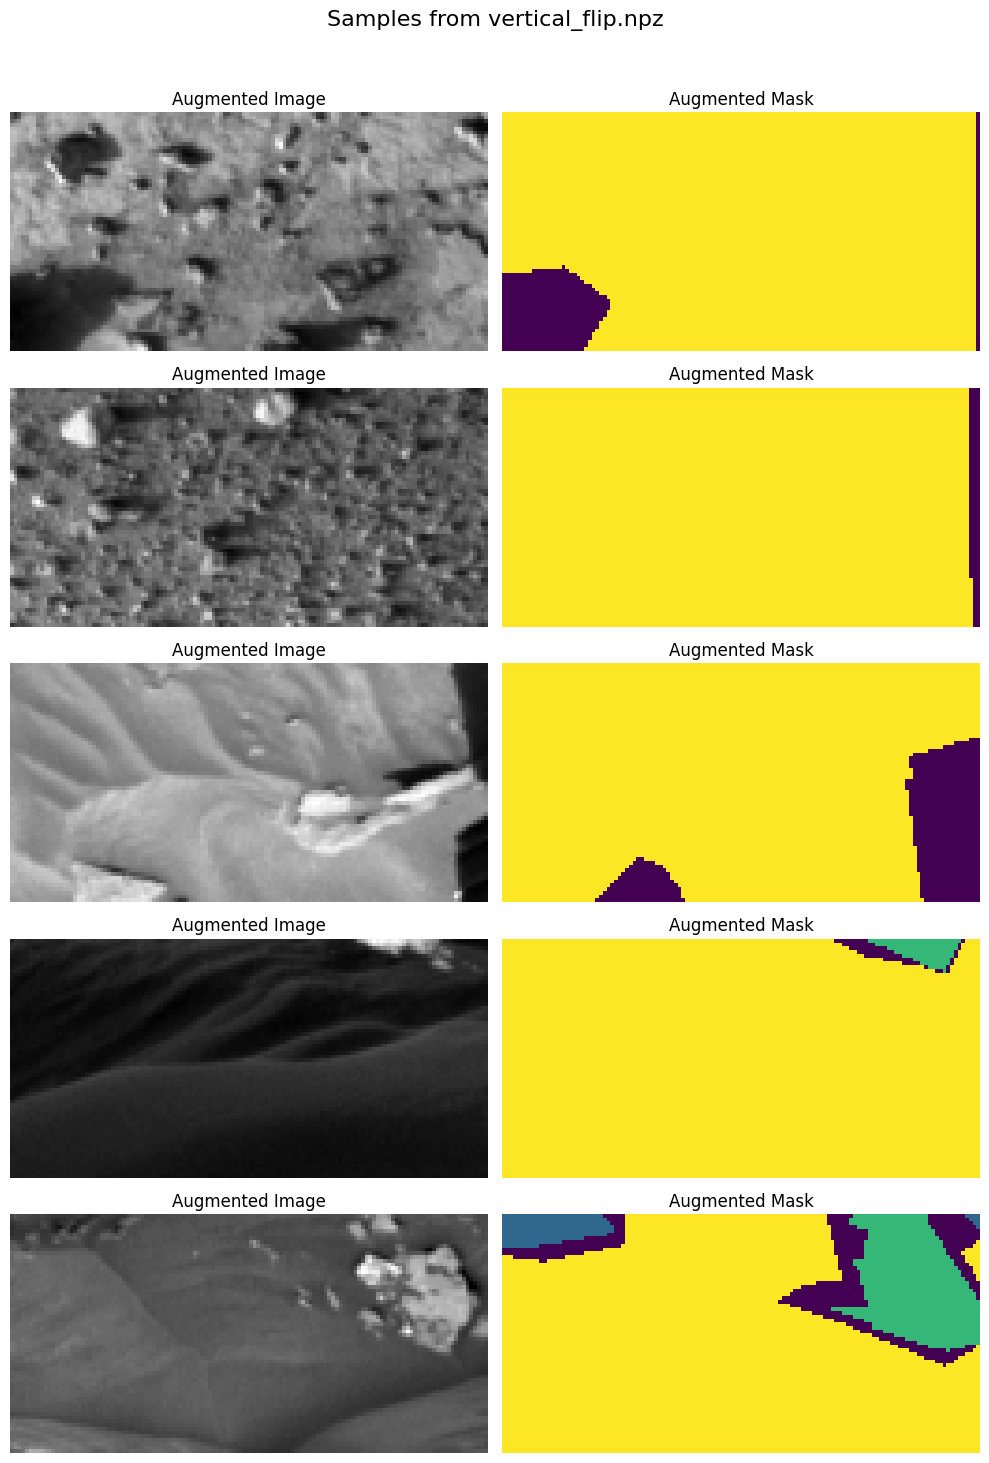

File: rotation_30°.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


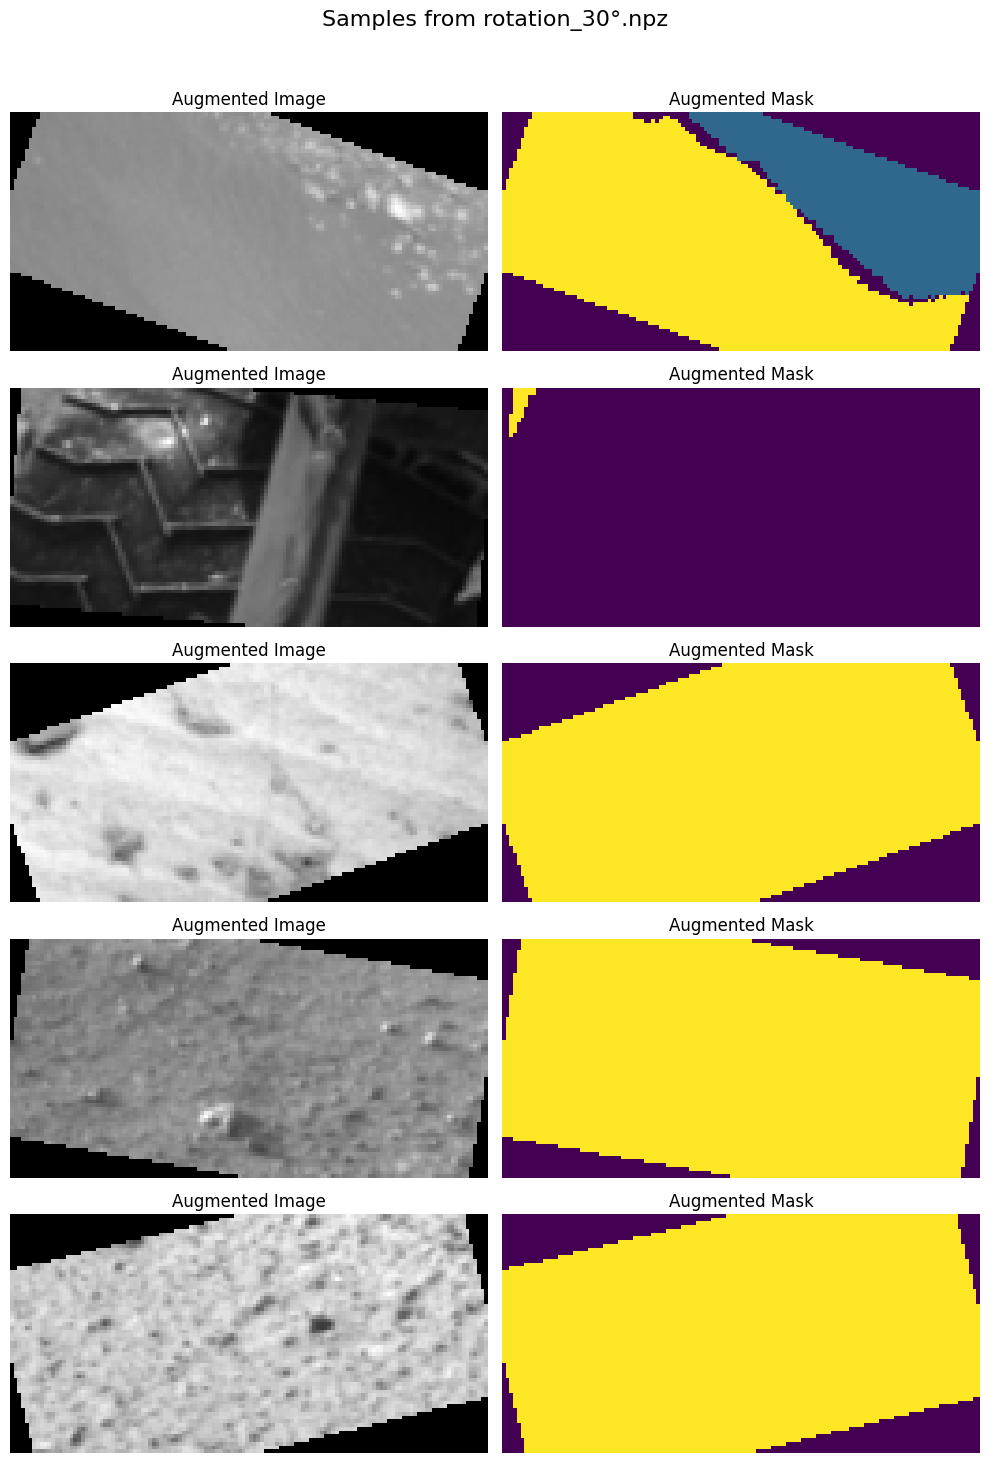

File: random_scale.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


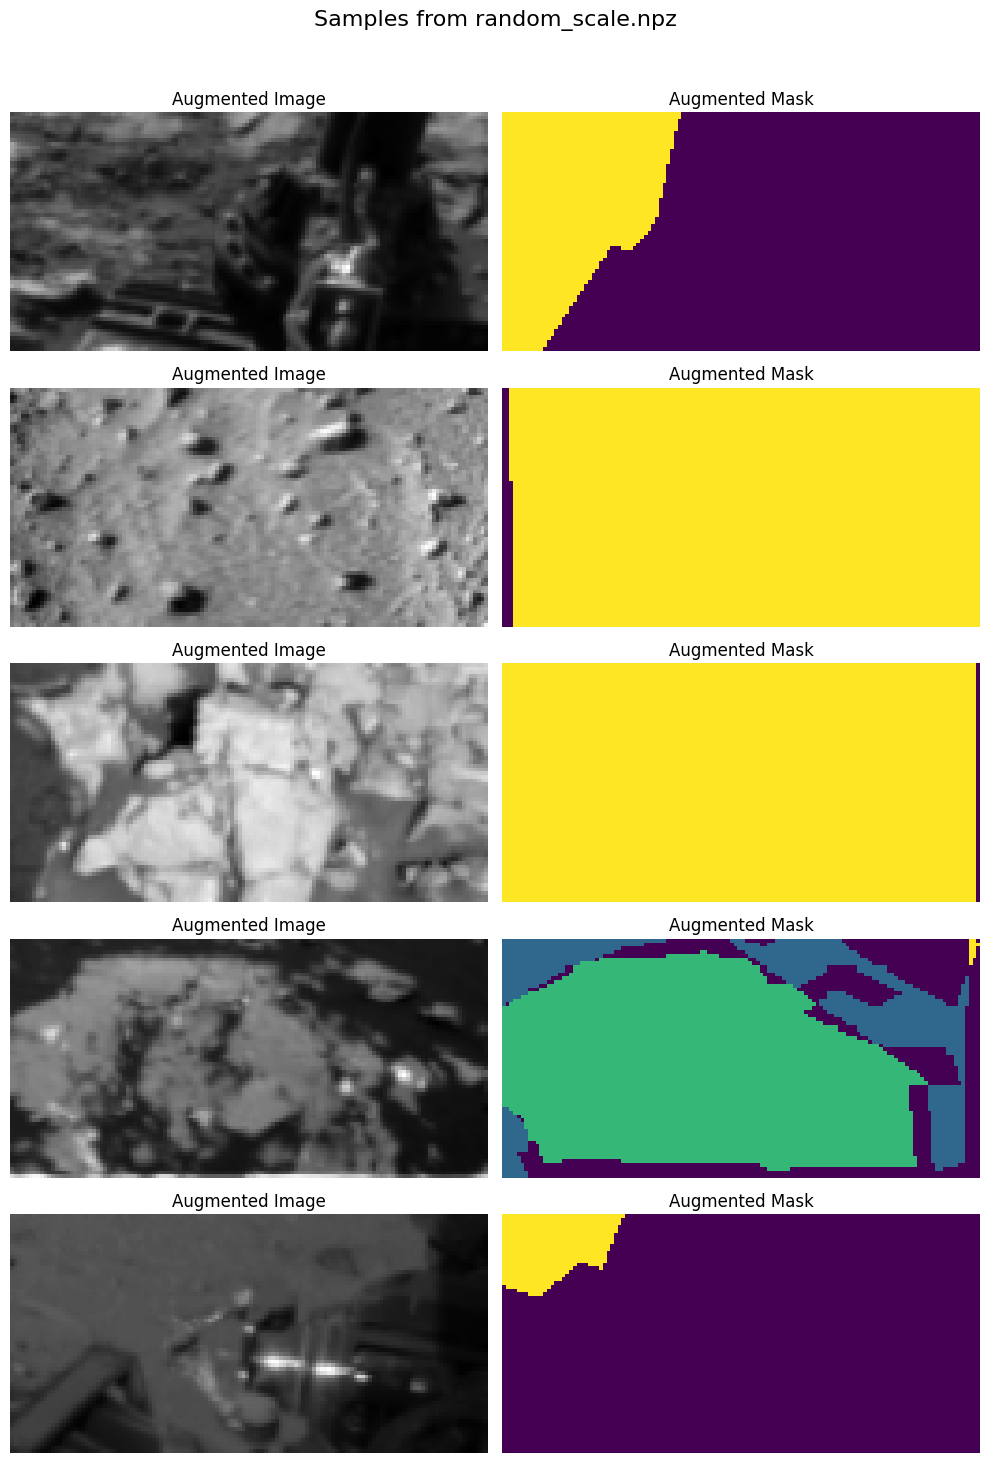

File: random_crop.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


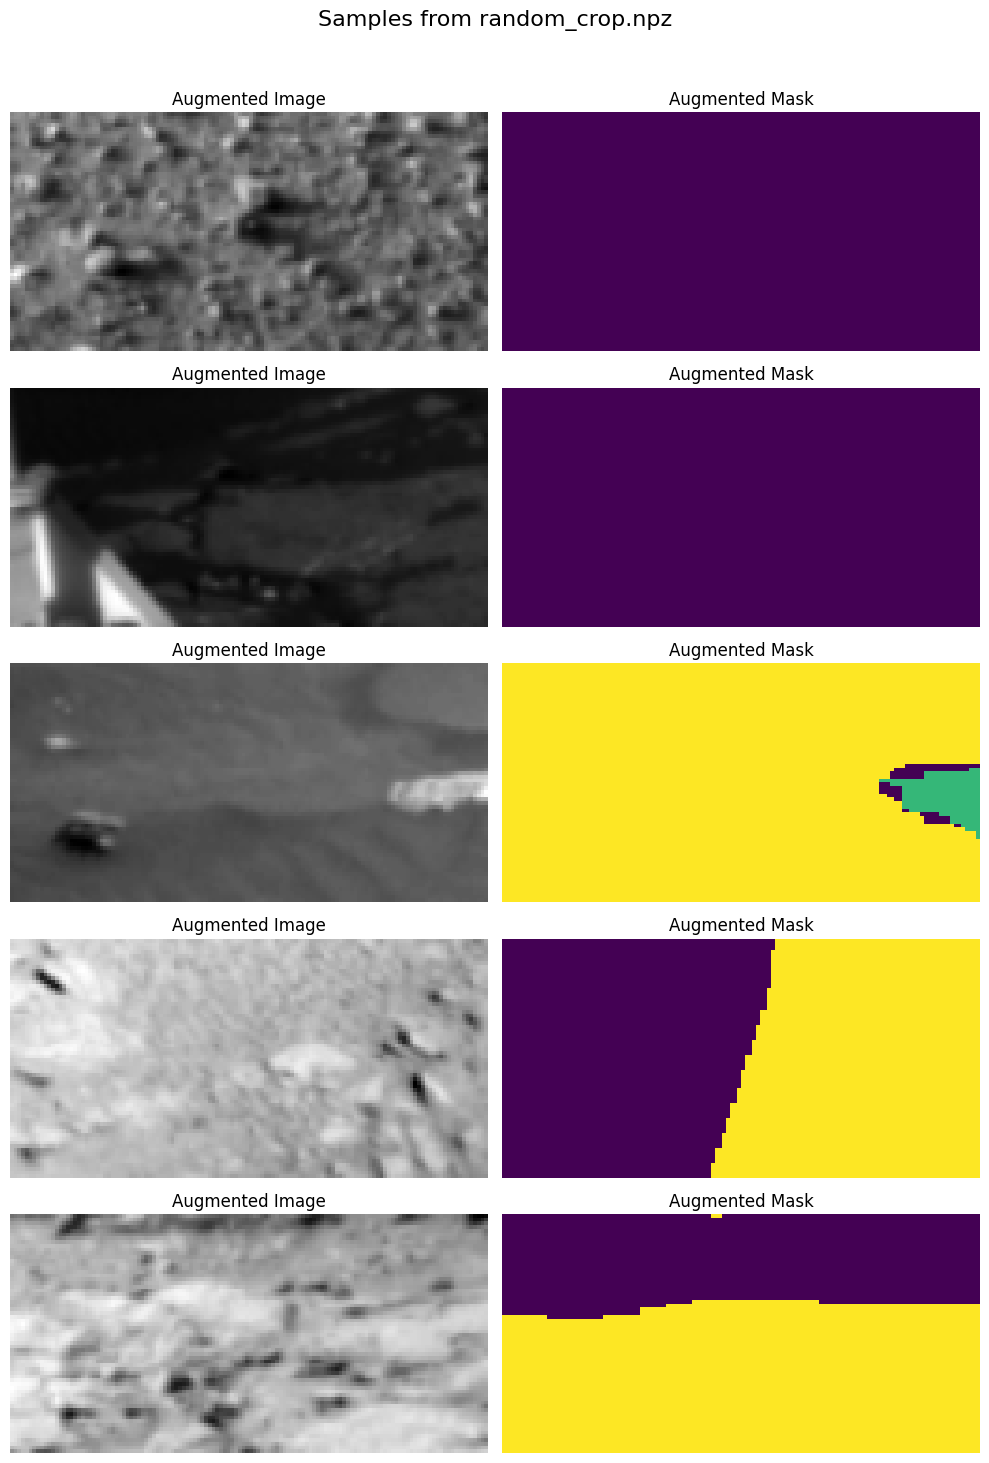

File: random_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


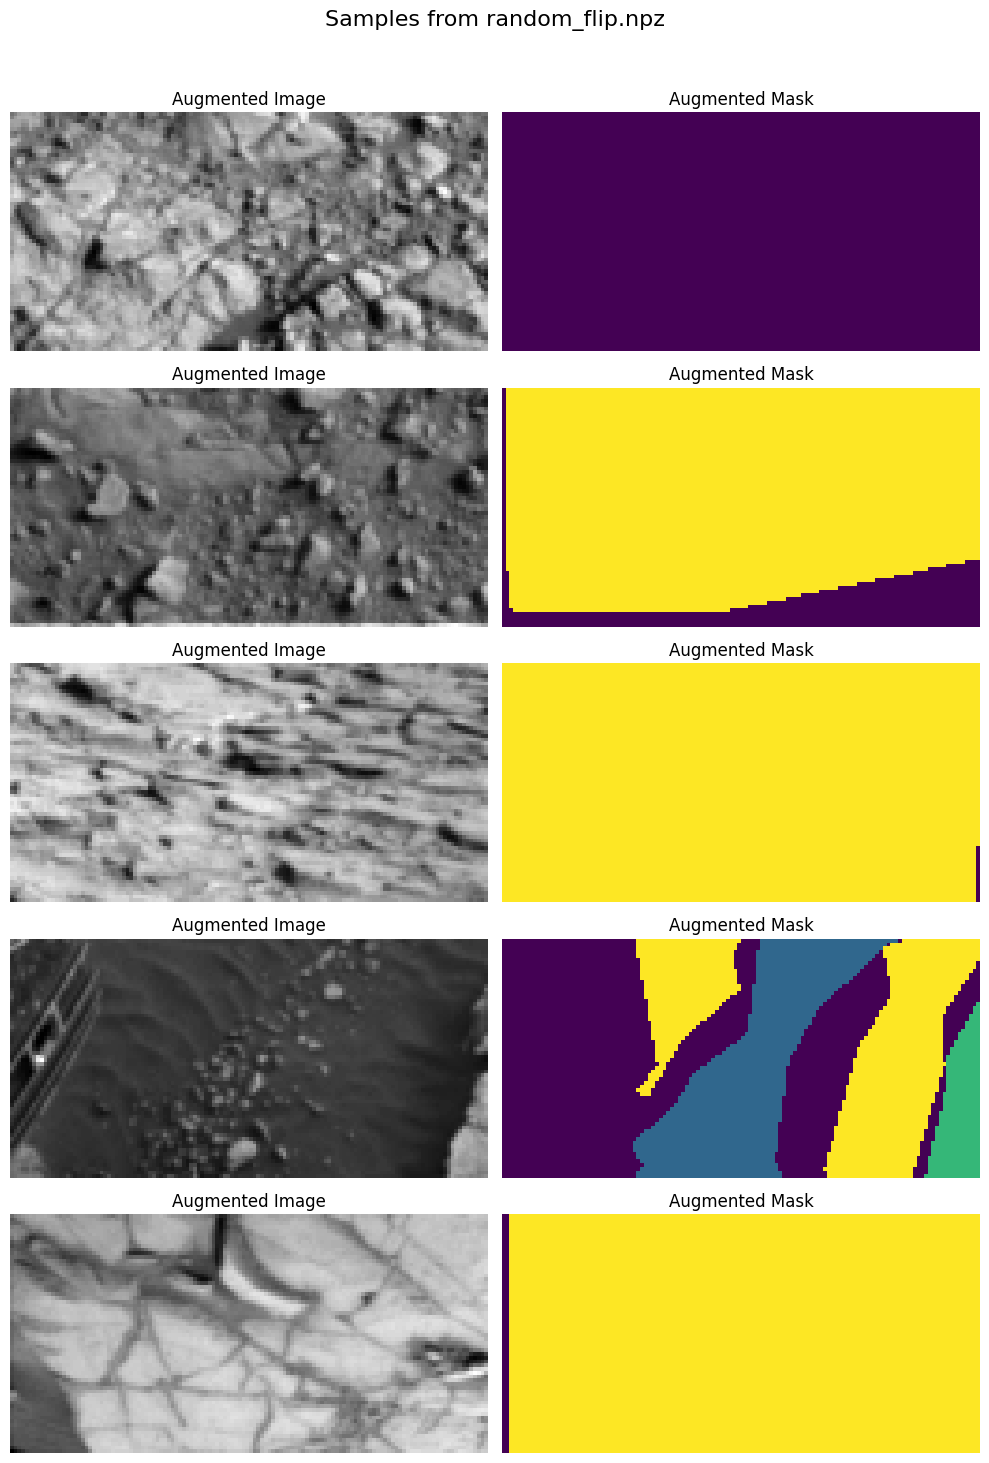

In [29]:
# Read the saved files and display details
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
        file_path = os.path.join(output_dir, file_name)
        data = np.load(file_path)

        # Display keys and their shapes
        print(f"File: {file_name}")
        for key in data.keys():
            print(f"  Key: {key}, Shape: {data[key].shape}")

        # Plot 5 random images and masks
        fig, axes = plt.subplots(5, 2, figsize=(10, 15))
        fig.suptitle(f"Samples from {file_name}", fontsize=16)
        for i in range(5):
            random_idx = np.random.randint(data["augmented_images"].shape[0])
            axes[i, 0].imshow(data["augmented_images"][random_idx], cmap="gray")
            axes[i, 0].set_title("Augmented Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(data["augmented_masks"][random_idx])
            axes[i, 1].set_title("Augmented Mask")
            axes[i, 1].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## 🛠️ Train and Save the Model

In [31]:
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
      # Load the rotation augmentation dataset
      s = output_dir+"/" + file_name
      data = np.load(s)

      # Extract augmented images and masks
      augmented_images = data["augmented_images"]
      augmented_masks = data["augmented_masks"]

      # Merge with original X_train and y_train
      X_train = np.concatenate([X_train, augmented_images], axis=0)
      y_train = np.concatenate([y_train, augmented_masks], axis=0)

      # Display the new shapes
      print(f"New X_train shape: {X_train.shape}")
      print(f"New y_train shape: {y_train.shape}")

New X_train shape: (4008, 64, 128)
New y_train shape: (4008, 64, 128)
New X_train shape: (6012, 64, 128)
New y_train shape: (6012, 64, 128)
New X_train shape: (8016, 64, 128)
New y_train shape: (8016, 64, 128)
New X_train shape: (10020, 64, 128)
New y_train shape: (10020, 64, 128)
New X_train shape: (12024, 64, 128)
New y_train shape: (12024, 64, 128)
New X_train shape: (14028, 64, 128)
New y_train shape: (14028, 64, 128)


In [32]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [33]:
X_val = X_val[..., np.newaxis] / 255.0

In [34]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (14028, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (14028, 64, 128)


In [35]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [36]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (14028, 64, 128, 1)
Shape of y_train after reshaping: (14028, 64, 128, 1)


In [37]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Data Augmentation for Images and Masks
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
)

# Masks should only be flipped or translated without interpolation
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Ensure y_train has the correct shape for augmentation
y_train = np.expand_dims(y_train, axis=-1)  # Add channel dimension to masks

# Fit augmentations to the data
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Create the generators
image_generator = image_datagen.flow(X_train, batch_size=32, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=42)

train_generator = zip(image_generator, mask_generator)

# Weighted Loss Function for Class Imbalance
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Remove the extra dimension from y_true using tf.squeeze
        y_true = tf.squeeze(y_true, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(weights))
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)

    return loss

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Use the calculated weights in the loss function
loss = weighted_categorical_crossentropy(class_weights)

# Define the U-Net Model
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c2)
    u1 = tf.keras.layers.concatenate([u1, c1])
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u1)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c3)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(c3)
    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
model = unet_model(input_shape, num_classes)
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model.summary()

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=15,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)

# Custom Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_datagen, mask_datagen, X_train, y_train, batch_size):
        self.image_datagen = image_datagen
        self.mask_datagen = mask_datagen
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X_train) / float(self.batch_size)))

    def __getitem__(self, idx):
      # Get the batch indices
      batch_x = self.X_train[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y_train[idx * self.batch_size:(idx + 1) * self.batch_size]

      # Apply augmentation
      # Use __next__() instead of next() for NumpyArrayIterator
      image_batch = self.image_datagen.flow(batch_x, batch_size=self.batch_size, shuffle=False).__next__()
      mask_batch = self.mask_datagen.flow(batch_y, batch_size=self.batch_size, shuffle=False).__next__()

      return image_batch, mask_batch  # Return image and mask batches


Shape of X_train after reshaping: (14028, 64, 128, 1)
Shape of y_train after reshaping: (14028, 64, 128)
Class pixel counts: [29334006 38063241 27027289 20346936   145904]
Calculated class weights: [0.00486979 0.00375297 0.00528541 0.00702073 0.97907109]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 64)    │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 128, 64)    │         32,832 │ conv2d_3[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 128, 128)   │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 128, 64)    │         73,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 128, 5)     │            325 │ conv2d_5[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 402,885 (1.54 MB)

 Trainable params: 402,885 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 128, 64)    │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 128, 64)    │            128 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 128, 64)    │              0 │ conv2d_8[0][0],        │
│                           │                        │                │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 64, 64)     │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 64, 128)    │        147,584 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 64, 128)    │          8,320 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 64, 128)    │              0 │ conv2d_11[0][0],       │
│                           │                        │                │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 32, 128)    │              0 │ add_1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 16, 32, 256)    │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 16, 32, 256)    │        590,080 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 16, 32, 256)    │         33,024 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 16, 32, 256)    │              0 │ conv2d_14[0][0],       │
│                           │                        │                │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 8, 16, 256)     │              0 │ add_2[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.3746 - loss: 1.3362 - mean_io_u: 0.1111
Epoch 1: val_loss improved from inf to 1.14565, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


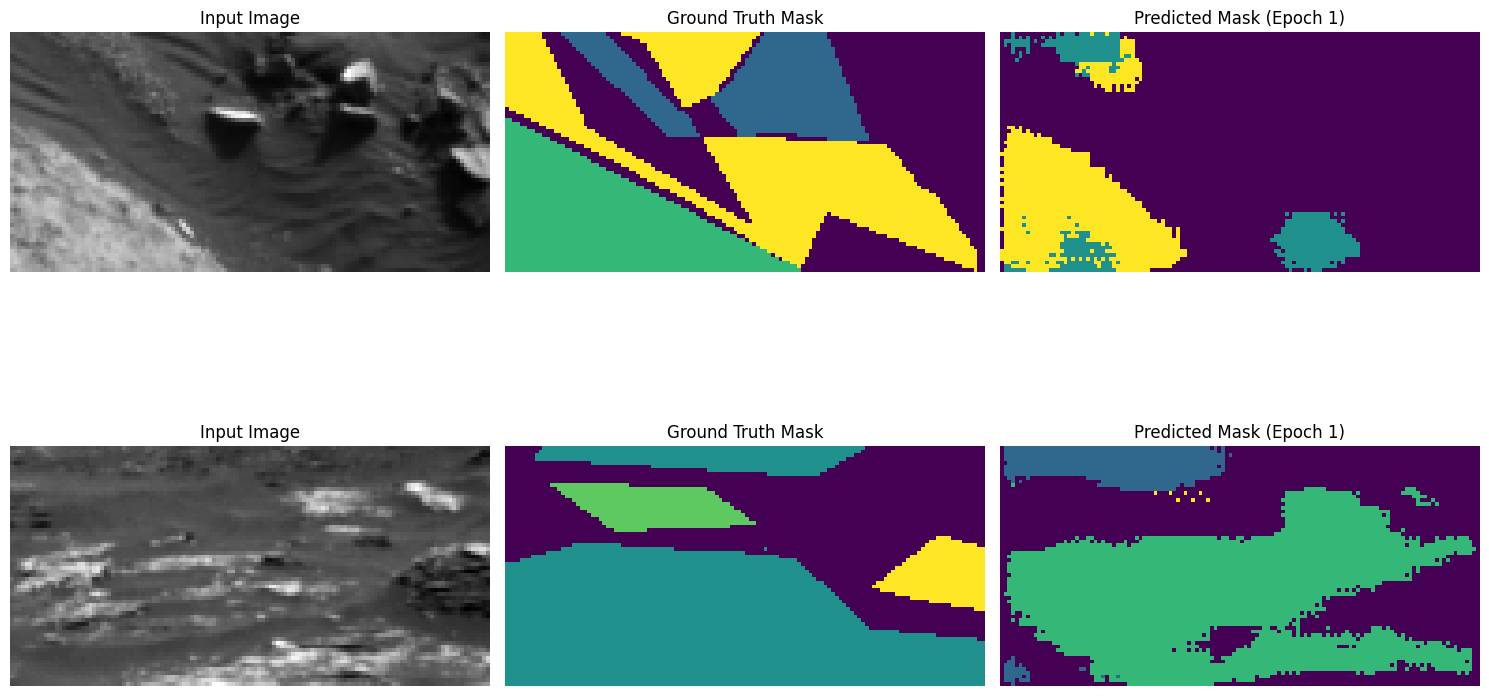

439/439 ━━━━━━━━━━━━━━━━━━━━ 220s 366ms/step - accuracy: 0.3747 - loss: 1.3360 - mean_io_u: 0.1112 - val_accuracy: 0.5047 - val_loss: 1.1456 - val_mean_io_u: 0.2248 - learning_rate: 1.0000e-04
Epoch 2/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5531 - loss: 1.0397 - mean_io_u: 0.2641
Epoch 2: val_loss improved from 1.14565 to 0.94932, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


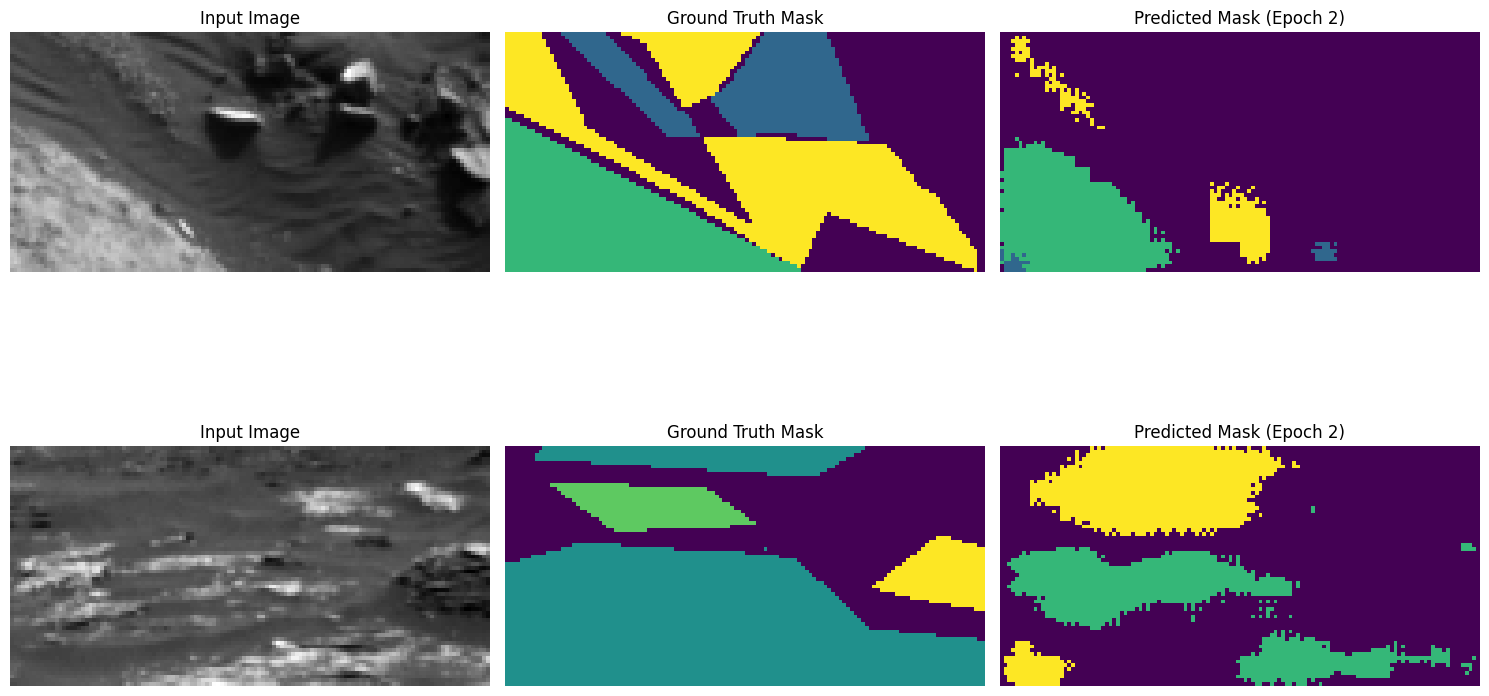

439/439 ━━━━━━━━━━━━━━━━━━━━ 149s 208ms/step - accuracy: 0.5531 - loss: 1.0396 - mean_io_u: 0.2641 - val_accuracy: 0.6331 - val_loss: 0.9493 - val_mean_io_u: 0.3377 - learning_rate: 1.0000e-04
Epoch 3/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6362 - loss: 0.9041 - mean_io_u: 0.3333
Epoch 3: val_loss improved from 0.94932 to 0.85337, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


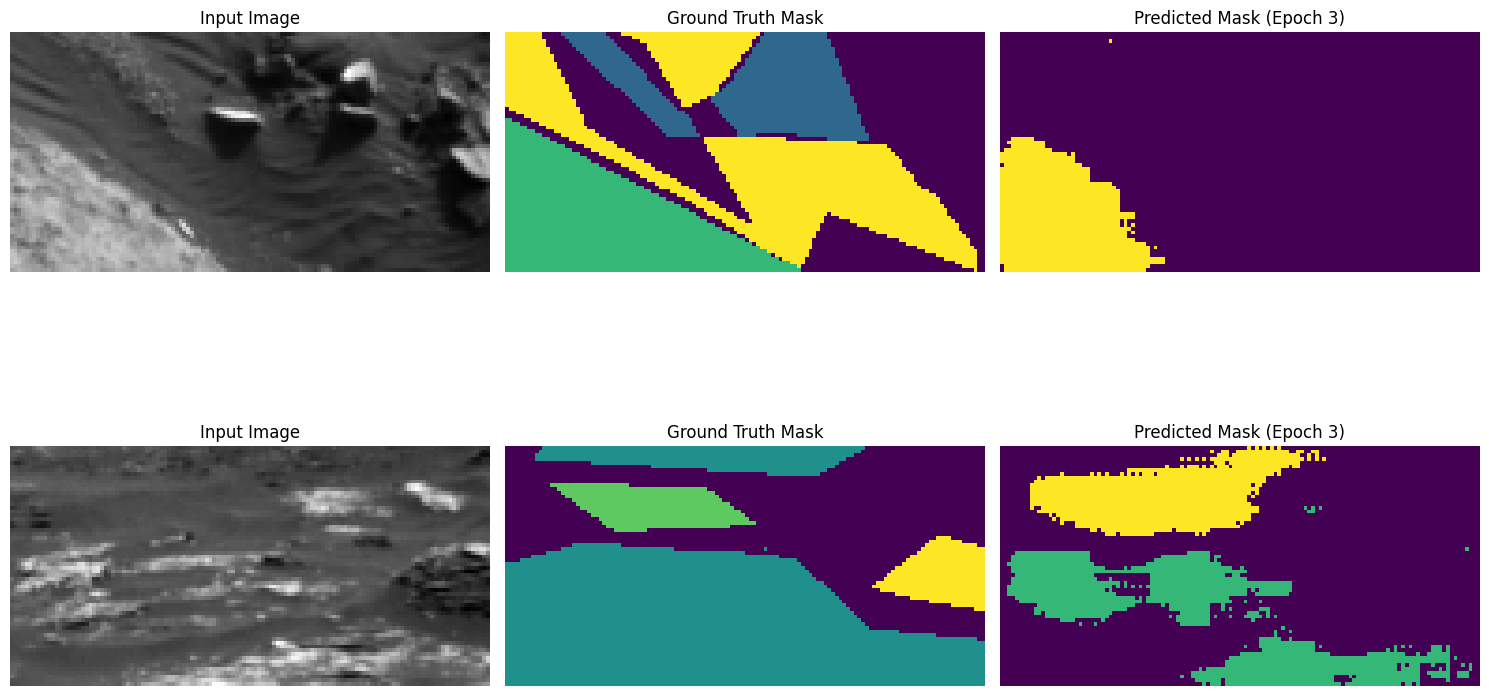

439/439 ━━━━━━━━━━━━━━━━━━━━ 141s 206ms/step - accuracy: 0.6362 - loss: 0.9041 - mean_io_u: 0.3332 - val_accuracy: 0.6775 - val_loss: 0.8534 - val_mean_io_u: 0.3739 - learning_rate: 1.0000e-04
Epoch 4/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6712 - loss: 0.8340 - mean_io_u: 0.3622
Epoch 4: val_loss improved from 0.85337 to 0.84161, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


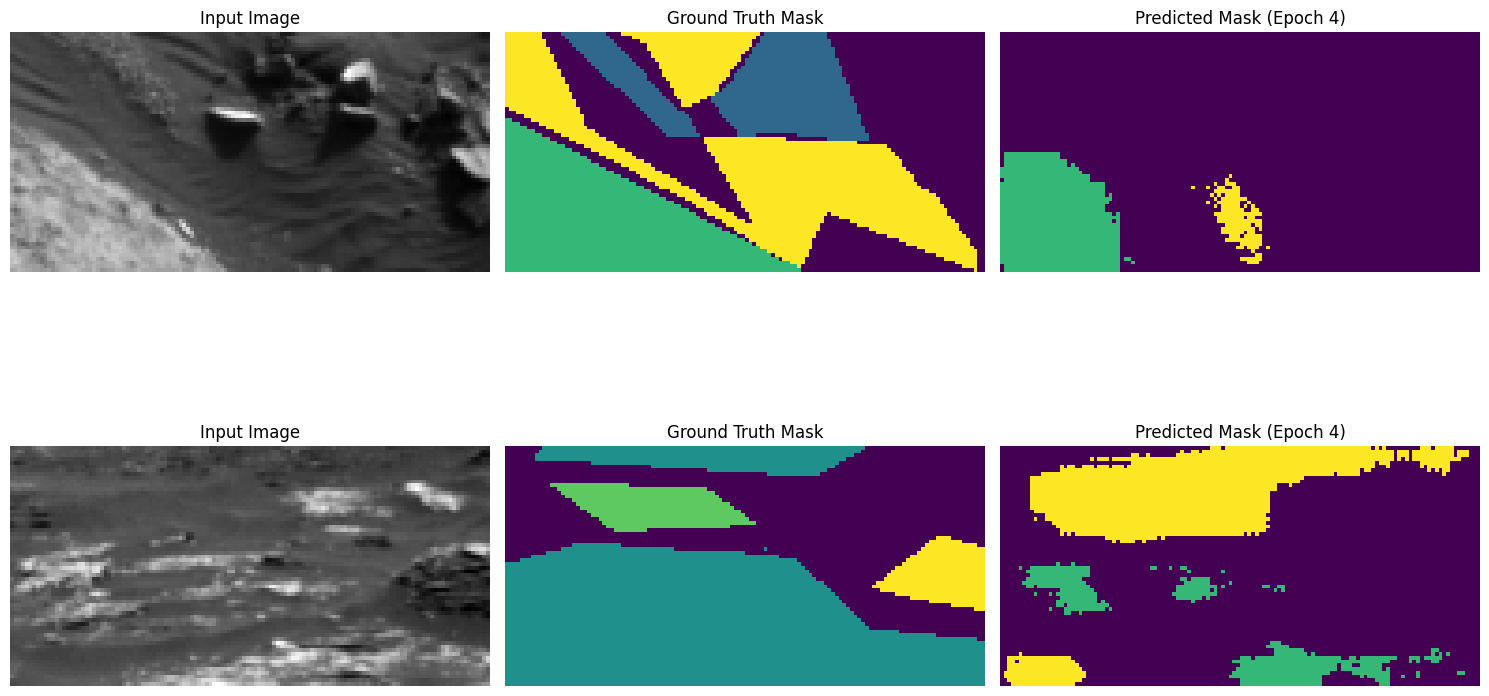

439/439 ━━━━━━━━━━━━━━━━━━━━ 144s 210ms/step - accuracy: 0.6712 - loss: 0.8340 - mean_io_u: 0.3622 - val_accuracy: 0.6834 - val_loss: 0.8416 - val_mean_io_u: 0.3723 - learning_rate: 1.0000e-04
Epoch 5/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6932 - loss: 0.7863 - mean_io_u: 0.3808
Epoch 5: val_loss improved from 0.84161 to 0.78849, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


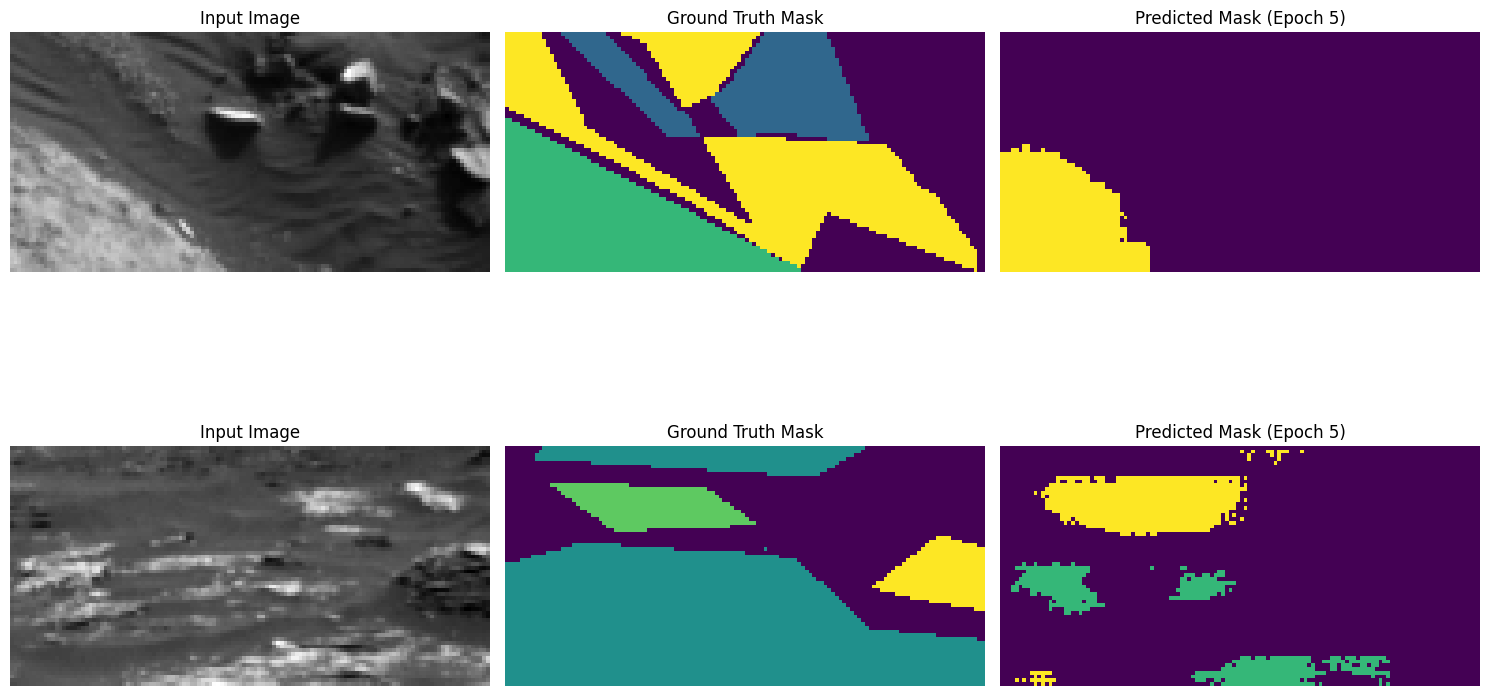

439/439 ━━━━━━━━━━━━━━━━━━━━ 140s 206ms/step - accuracy: 0.6932 - loss: 0.7863 - mean_io_u: 0.3807 - val_accuracy: 0.7011 - val_loss: 0.7885 - val_mean_io_u: 0.3817 - learning_rate: 1.0000e-04
Epoch 6/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7101 - loss: 0.7437 - mean_io_u: 0.3962
Epoch 6: val_loss improved from 0.78849 to 0.77045, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


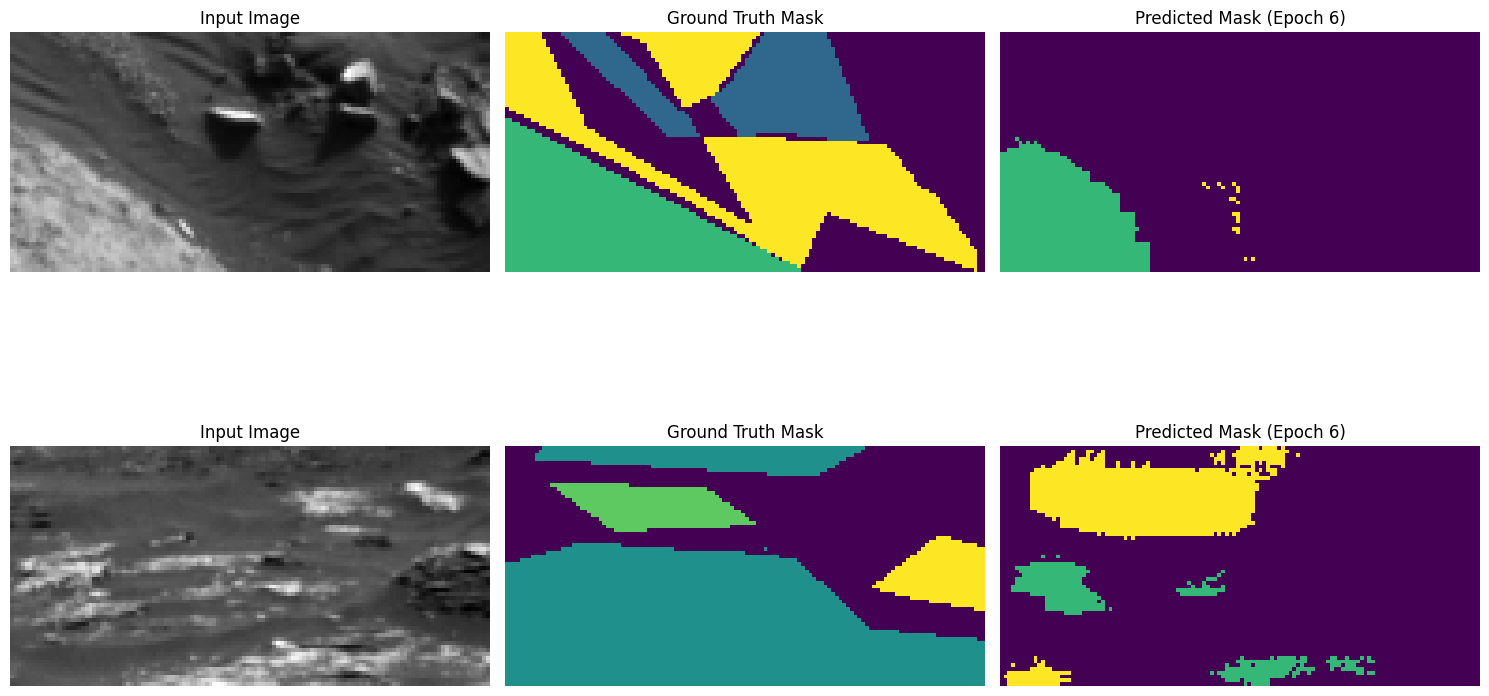

439/439 ━━━━━━━━━━━━━━━━━━━━ 143s 210ms/step - accuracy: 0.7101 - loss: 0.7437 - mean_io_u: 0.3961 - val_accuracy: 0.7051 - val_loss: 0.7704 - val_mean_io_u: 0.3866 - learning_rate: 1.0000e-04
Epoch 7/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7270 - loss: 0.6999 - mean_io_u: 0.4130
Epoch 7: val_loss improved from 0.77045 to 0.71264, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


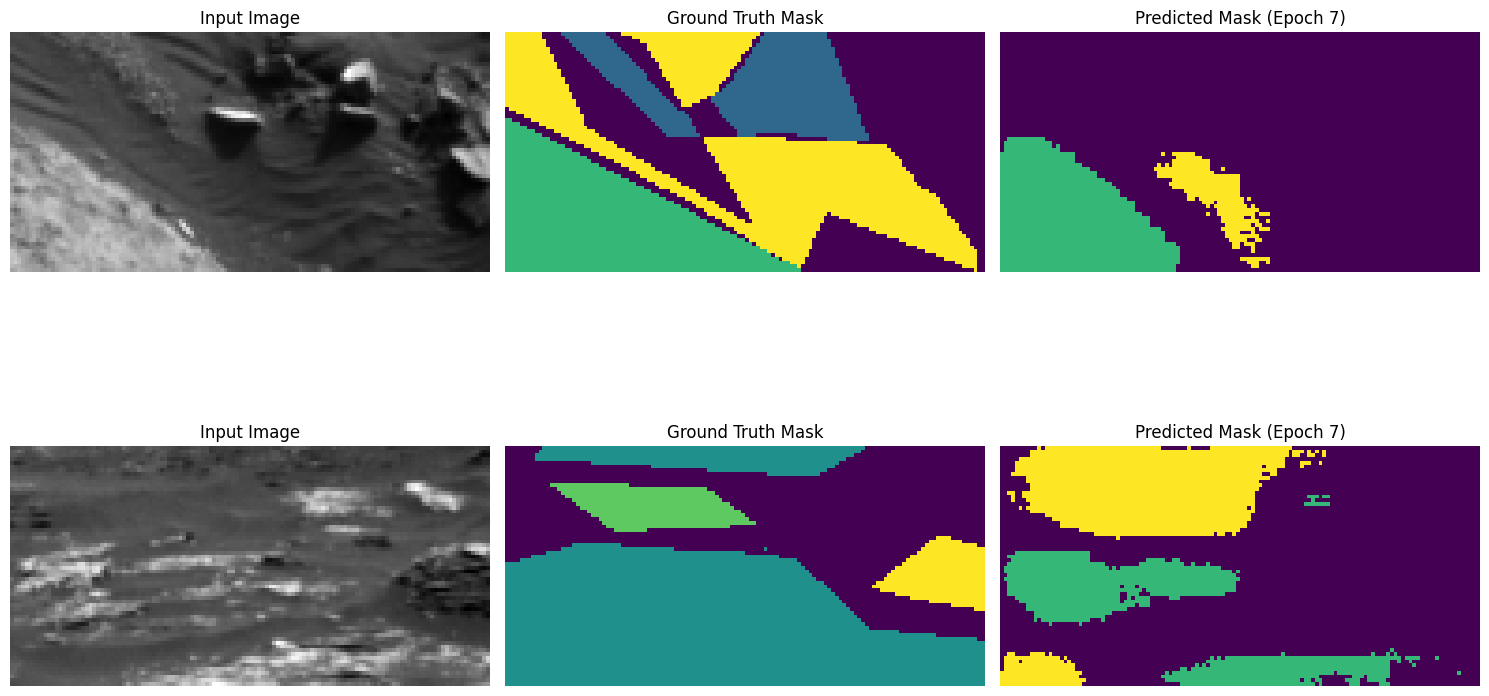

439/439 ━━━━━━━━━━━━━━━━━━━━ 92s 210ms/step - accuracy: 0.7271 - loss: 0.6999 - mean_io_u: 0.4130 - val_accuracy: 0.7323 - val_loss: 0.7126 - val_mean_io_u: 0.4192 - learning_rate: 1.0000e-04
Epoch 8/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7384 - loss: 0.6697 - mean_io_u: 0.4245
Epoch 8: val_loss improved from 0.71264 to 0.70209, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


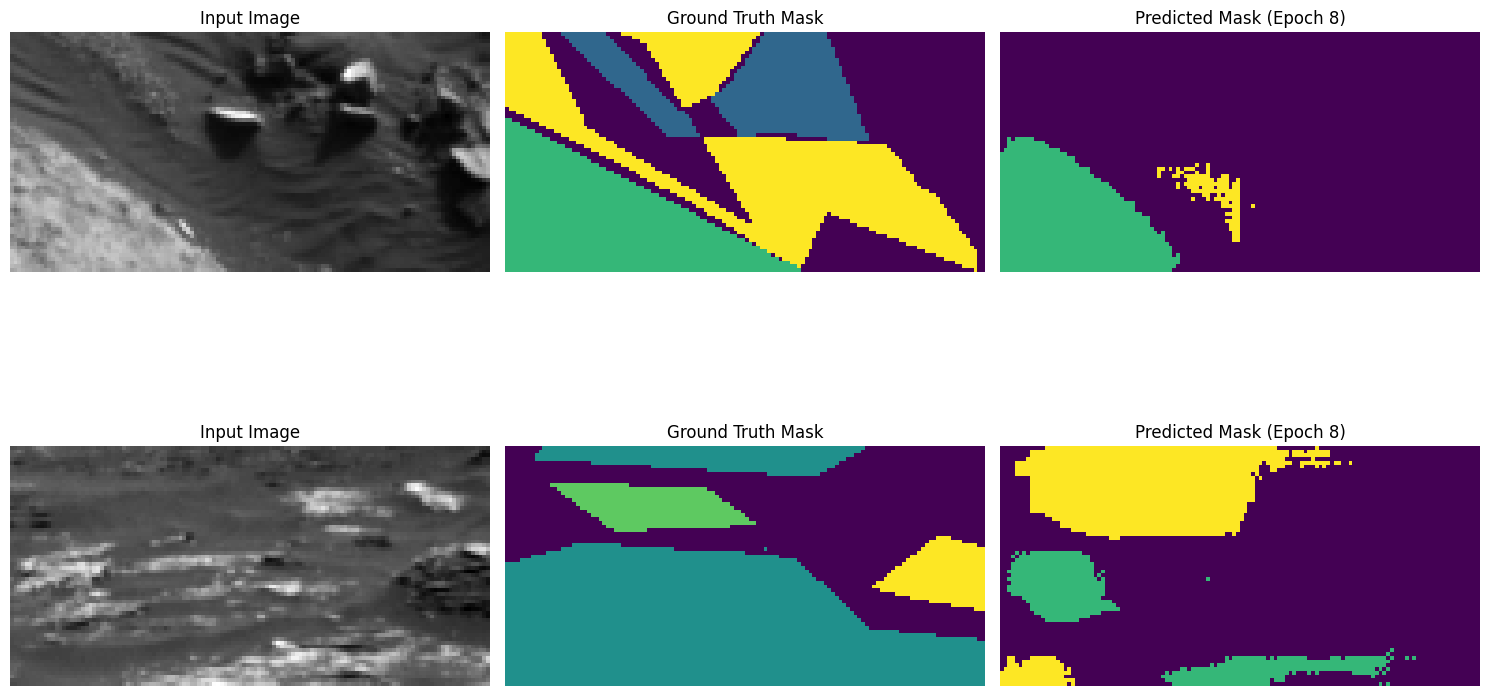

439/439 ━━━━━━━━━━━━━━━━━━━━ 93s 212ms/step - accuracy: 0.7384 - loss: 0.6697 - mean_io_u: 0.4244 - val_accuracy: 0.7332 - val_loss: 0.7021 - val_mean_io_u: 0.4171 - learning_rate: 1.0000e-04
Epoch 9/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7480 - loss: 0.6445 - mean_io_u: 0.4344
Epoch 9: val_loss improved from 0.70209 to 0.68738, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


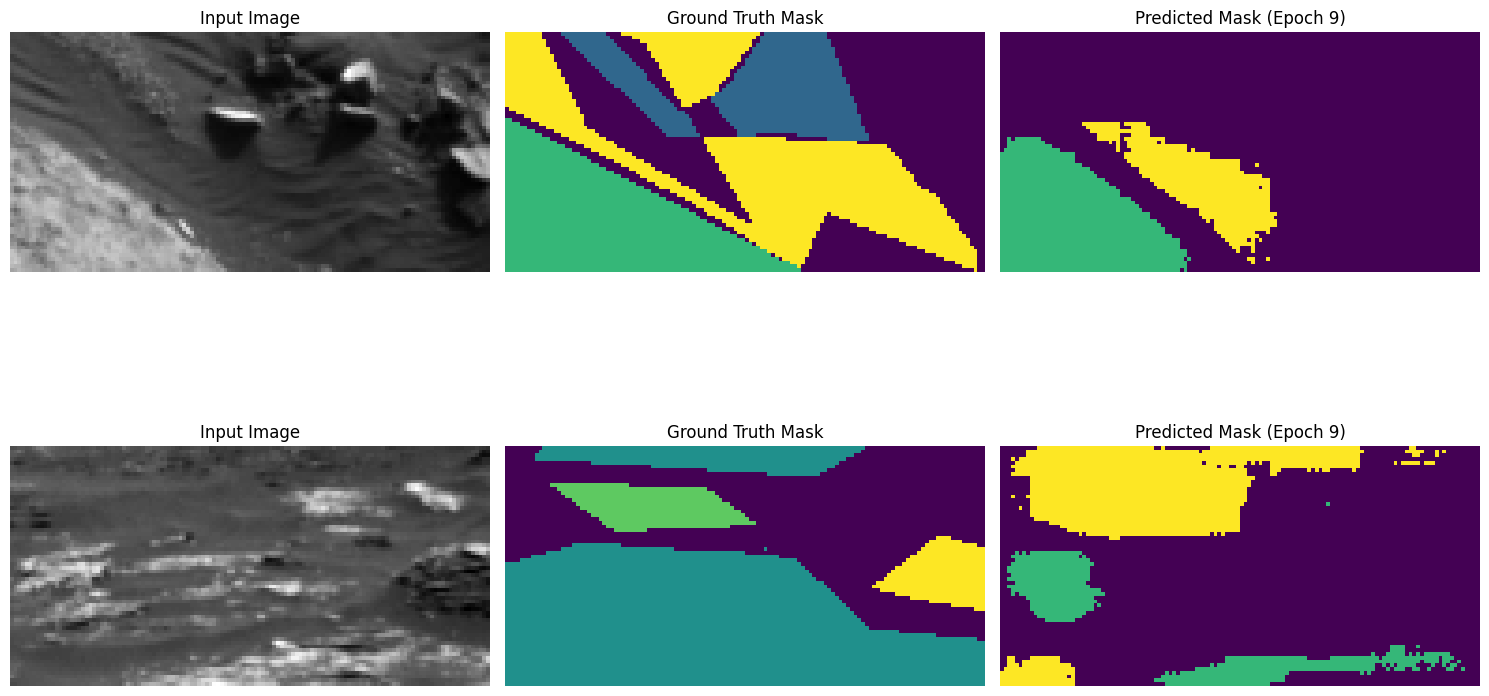

439/439 ━━━━━━━━━━━━━━━━━━━━ 140s 207ms/step - accuracy: 0.7480 - loss: 0.6445 - mean_io_u: 0.4344 - val_accuracy: 0.7360 - val_loss: 0.6874 - val_mean_io_u: 0.4196 - learning_rate: 1.0000e-04
Epoch 10/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7616 - loss: 0.6118 - mean_io_u: 0.4470
Epoch 10: val_loss improved from 0.68738 to 0.67429, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


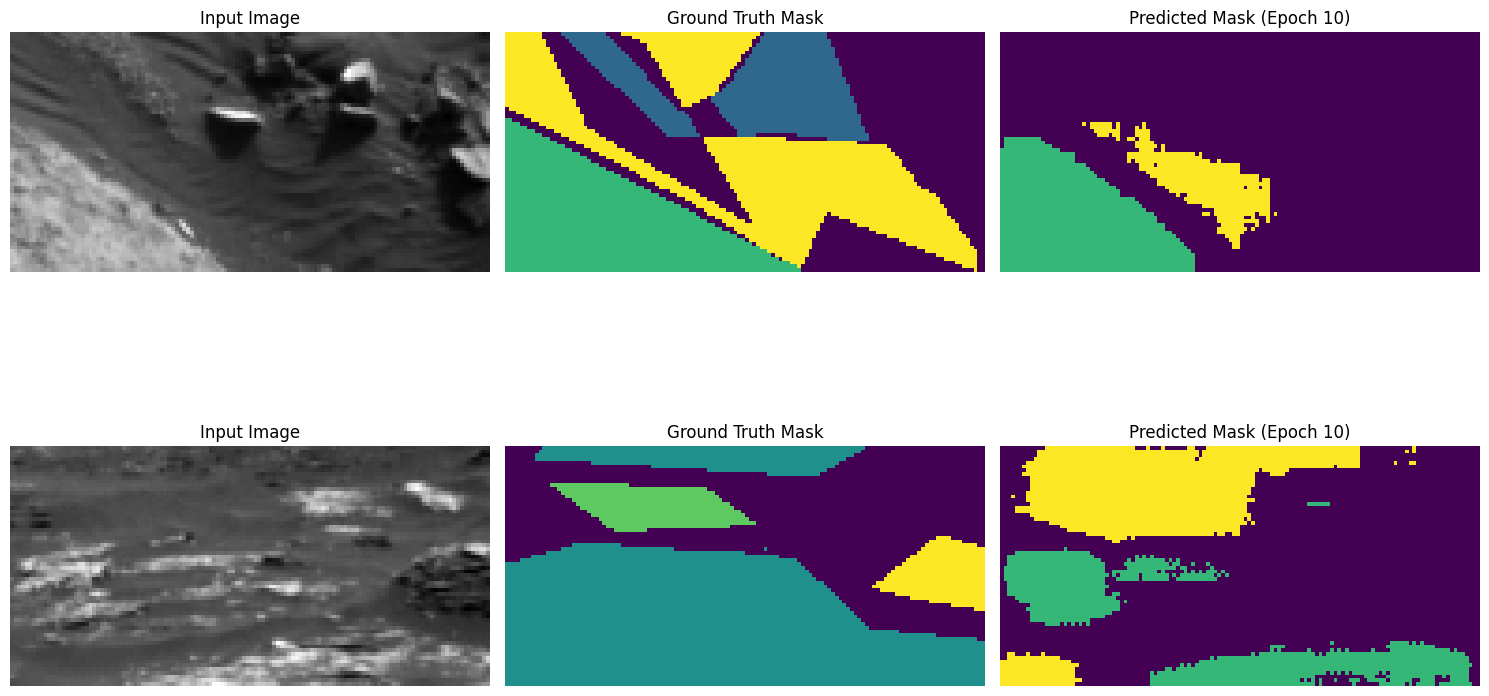

439/439 ━━━━━━━━━━━━━━━━━━━━ 92s 208ms/step - accuracy: 0.7616 - loss: 0.6118 - mean_io_u: 0.4469 - val_accuracy: 0.7385 - val_loss: 0.6743 - val_mean_io_u: 0.4194 - learning_rate: 1.0000e-04
Epoch 11/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7715 - loss: 0.5866 - mean_io_u: 0.4564
Epoch 11: val_loss improved from 0.67429 to 0.66183, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


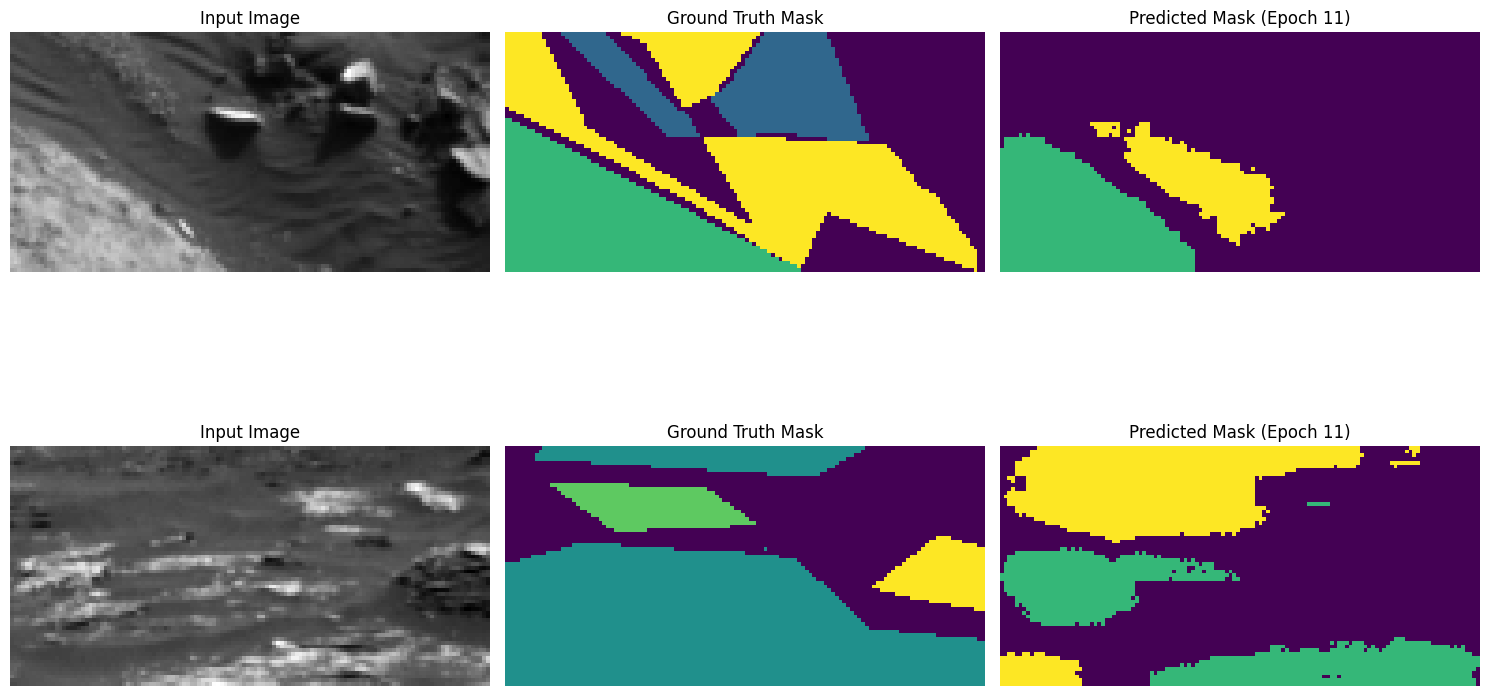

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 208ms/step - accuracy: 0.7715 - loss: 0.5866 - mean_io_u: 0.4563 - val_accuracy: 0.7450 - val_loss: 0.6618 - val_mean_io_u: 0.4273 - learning_rate: 1.0000e-04
Epoch 12/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7795 - loss: 0.5665 - mean_io_u: 0.4630
Epoch 12: val_loss improved from 0.66183 to 0.64456, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


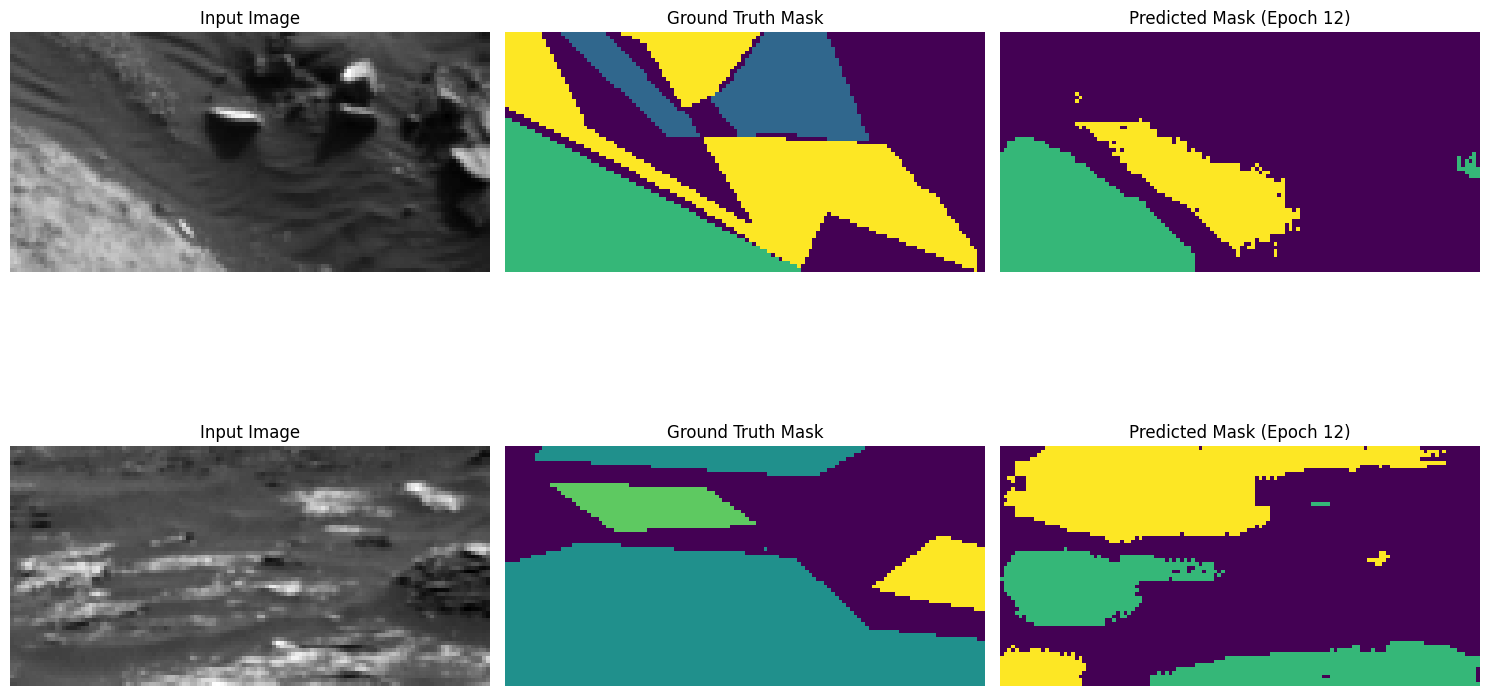

439/439 ━━━━━━━━━━━━━━━━━━━━ 143s 212ms/step - accuracy: 0.7795 - loss: 0.5665 - mean_io_u: 0.4629 - val_accuracy: 0.7505 - val_loss: 0.6446 - val_mean_io_u: 0.4357 - learning_rate: 1.0000e-04
Epoch 13/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7872 - loss: 0.5467 - mean_io_u: 0.4701
Epoch 13: val_loss improved from 0.64456 to 0.63519, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


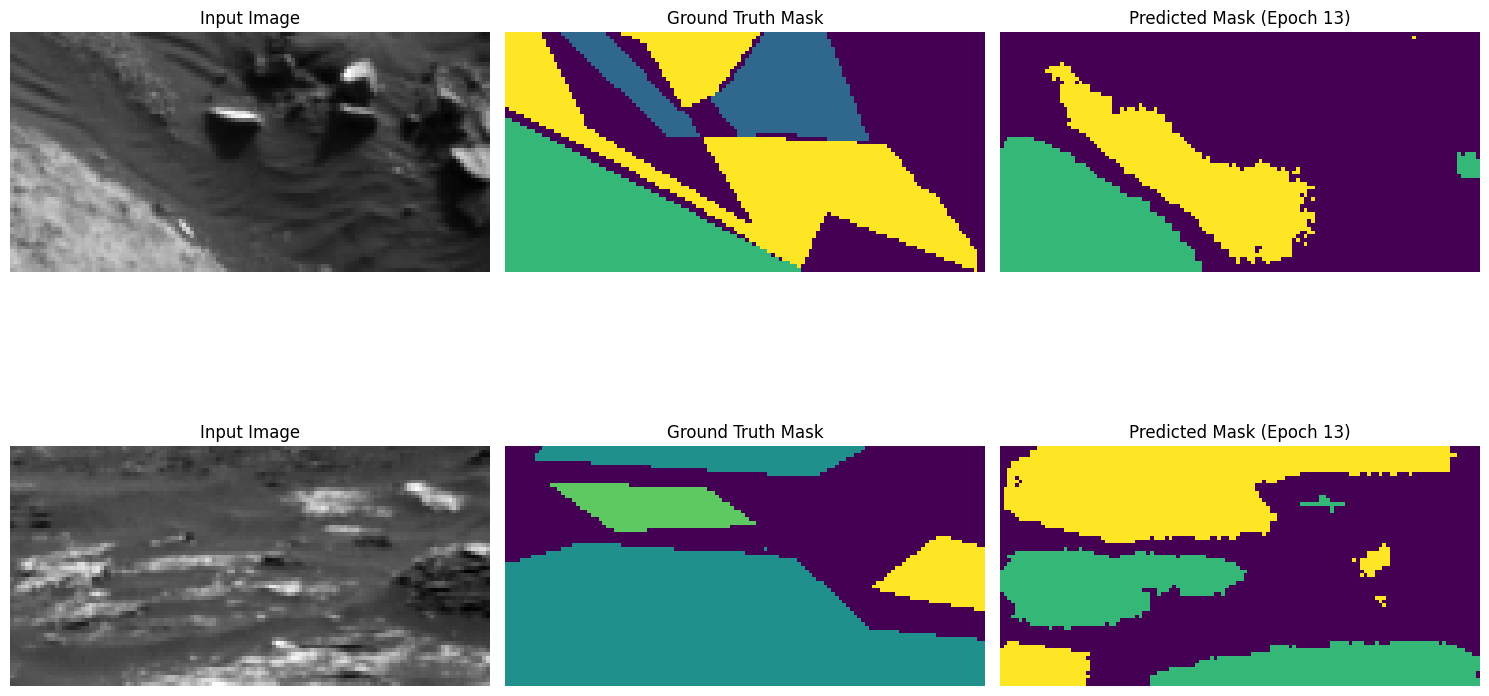

439/439 ━━━━━━━━━━━━━━━━━━━━ 140s 208ms/step - accuracy: 0.7872 - loss: 0.5467 - mean_io_u: 0.4701 - val_accuracy: 0.7556 - val_loss: 0.6352 - val_mean_io_u: 0.4406 - learning_rate: 1.0000e-04
Epoch 14/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7960 - loss: 0.5256 - mean_io_u: 0.4774
Epoch 14: val_loss improved from 0.63519 to 0.63388, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


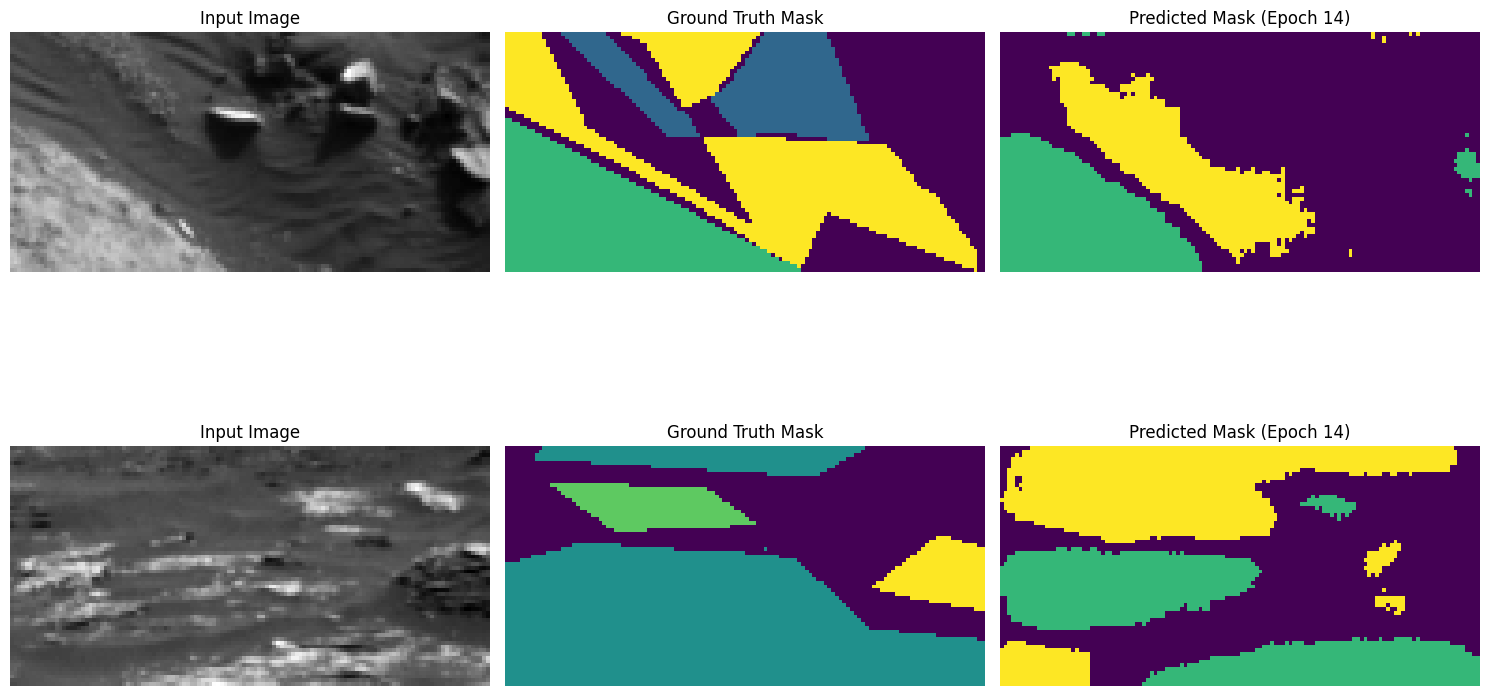

439/439 ━━━━━━━━━━━━━━━━━━━━ 91s 208ms/step - accuracy: 0.7960 - loss: 0.5256 - mean_io_u: 0.4773 - val_accuracy: 0.7584 - val_loss: 0.6339 - val_mean_io_u: 0.4425 - learning_rate: 1.0000e-04
Epoch 15/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8054 - loss: 0.5030 - mean_io_u: 0.4870
Epoch 15: val_loss improved from 0.63388 to 0.62921, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


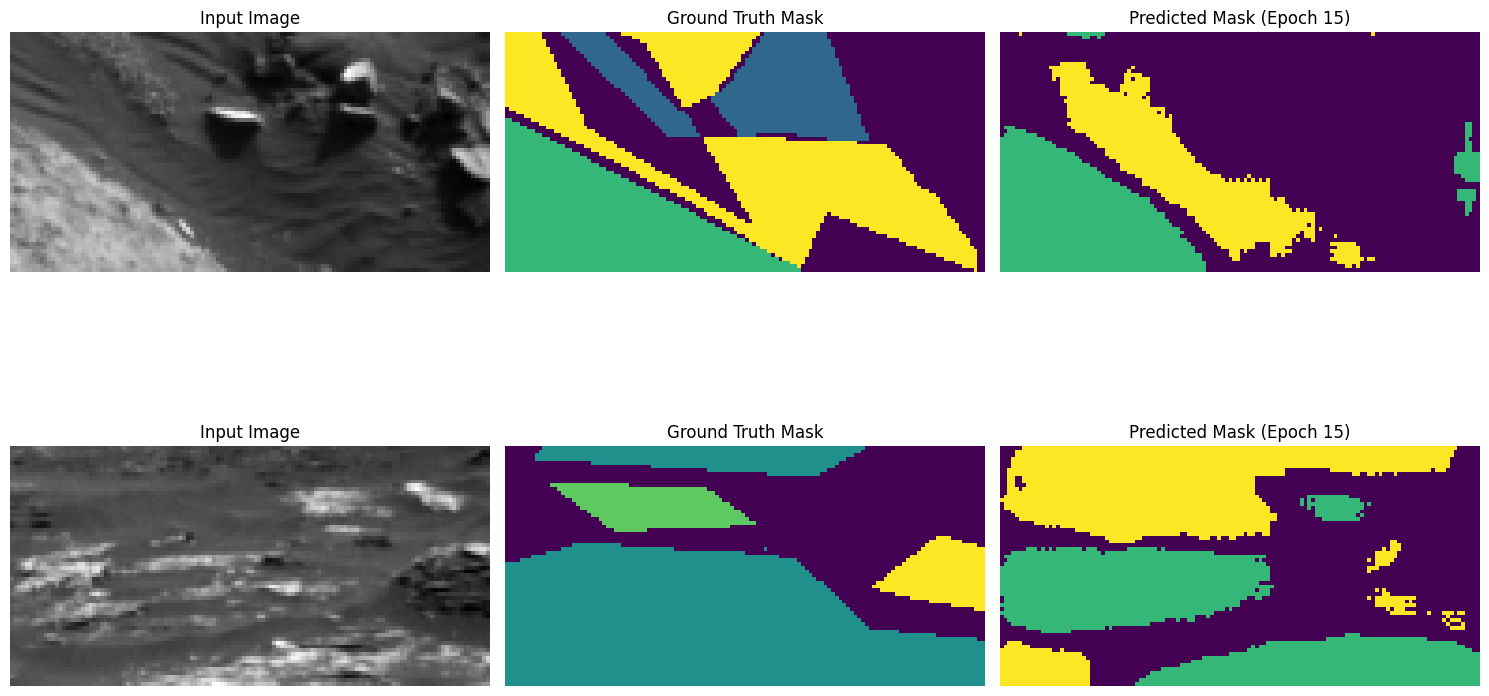

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 208ms/step - accuracy: 0.8054 - loss: 0.5030 - mean_io_u: 0.4869 - val_accuracy: 0.7606 - val_loss: 0.6292 - val_mean_io_u: 0.4435 - learning_rate: 1.0000e-04
Epoch 16/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8159 - loss: 0.4773 - mean_io_u: 0.4977
Epoch 16: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


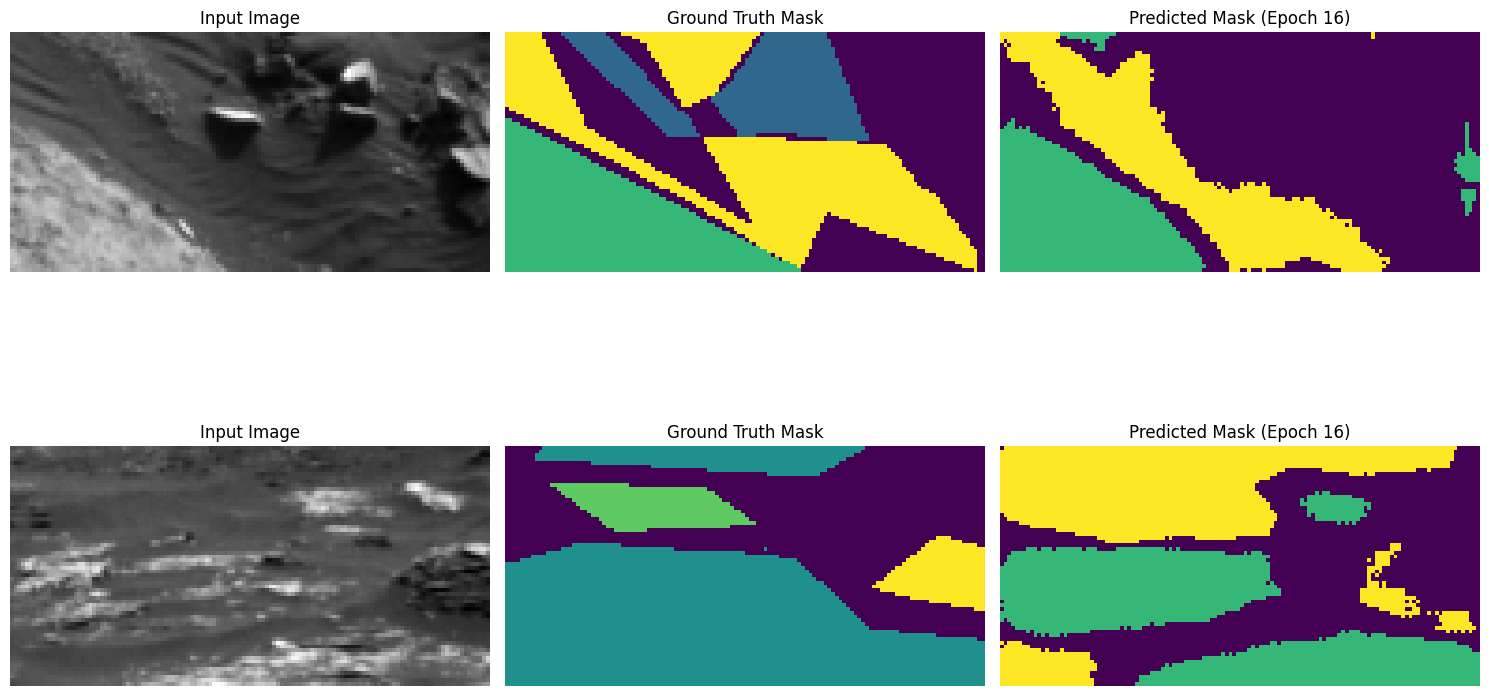

439/439 ━━━━━━━━━━━━━━━━━━━━ 89s 202ms/step - accuracy: 0.8159 - loss: 0.4773 - mean_io_u: 0.4977 - val_accuracy: 0.7614 - val_loss: 0.6311 - val_mean_io_u: 0.4455 - learning_rate: 1.0000e-04
Epoch 17/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8239 - loss: 0.4569 - mean_io_u: 0.5062
Epoch 17: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


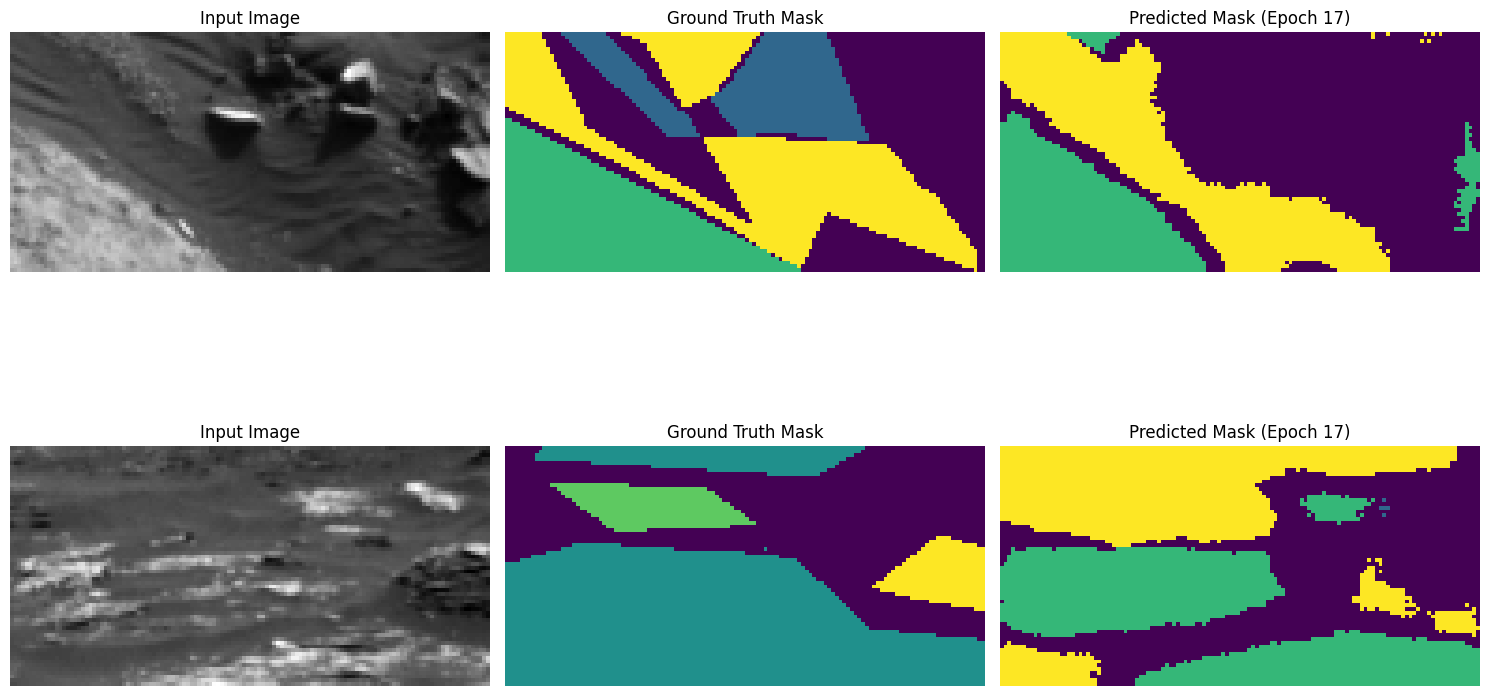

439/439 ━━━━━━━━━━━━━━━━━━━━ 144s 206ms/step - accuracy: 0.8239 - loss: 0.4569 - mean_io_u: 0.5062 - val_accuracy: 0.7618 - val_loss: 0.6425 - val_mean_io_u: 0.4465 - learning_rate: 1.0000e-04
Epoch 18/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8344 - loss: 0.4324 - mean_io_u: 0.5175
Epoch 18: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


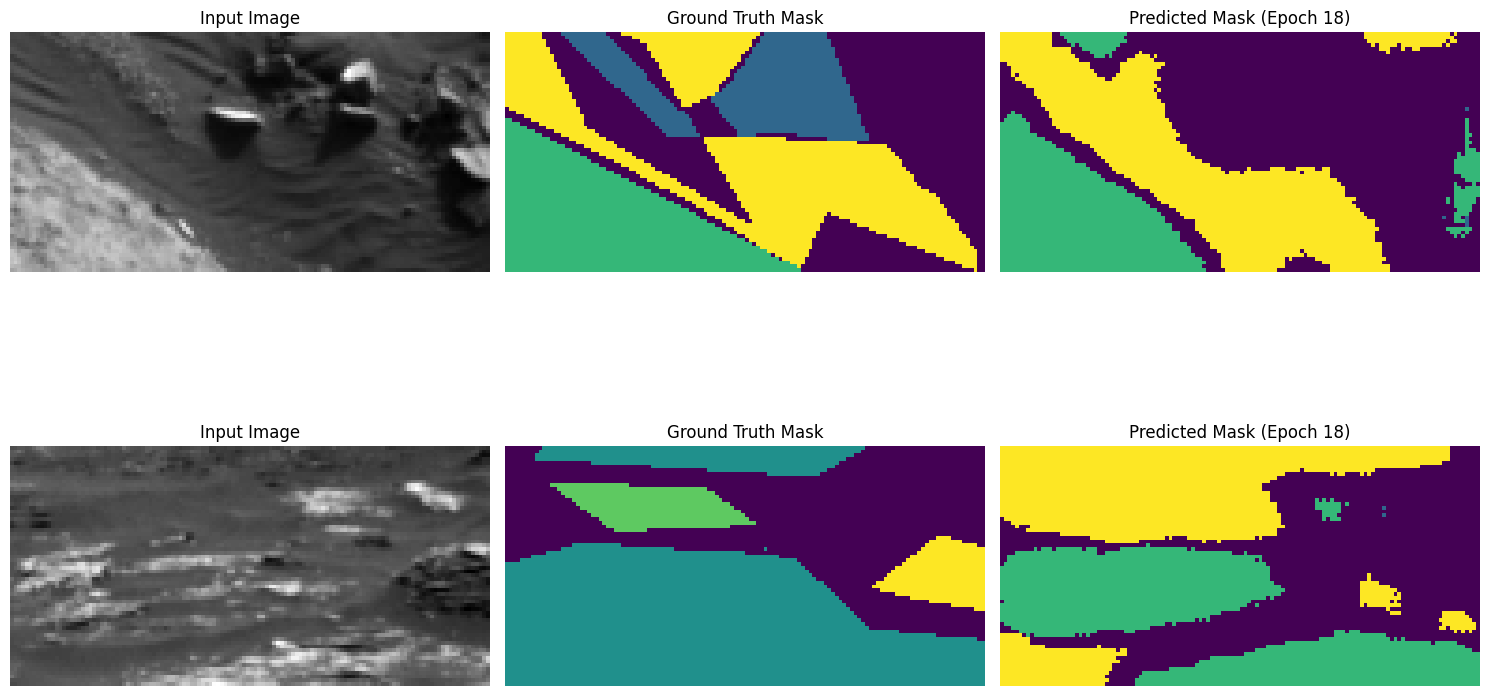

439/439 ━━━━━━━━━━━━━━━━━━━━ 89s 203ms/step - accuracy: 0.8344 - loss: 0.4324 - mean_io_u: 0.5174 - val_accuracy: 0.7626 - val_loss: 0.6447 - val_mean_io_u: 0.4484 - learning_rate: 1.0000e-04
Epoch 19/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8422 - loss: 0.4128 - mean_io_u: 0.5262
Epoch 19: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


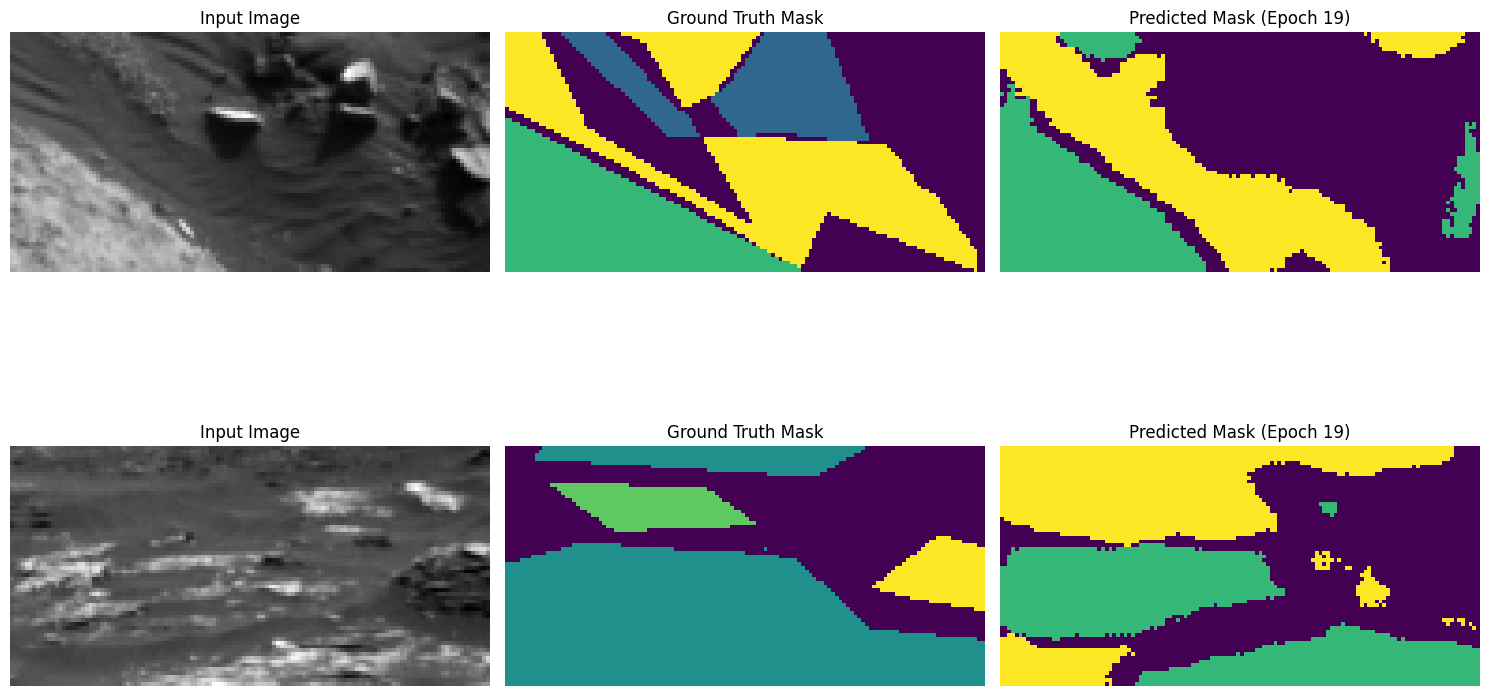

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 204ms/step - accuracy: 0.8422 - loss: 0.4128 - mean_io_u: 0.5261 - val_accuracy: 0.7635 - val_loss: 0.6644 - val_mean_io_u: 0.4496 - learning_rate: 1.0000e-04
Epoch 20/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8524 - loss: 0.3876 - mean_io_u: 0.5384
Epoch 20: val_loss did not improve from 0.62921

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


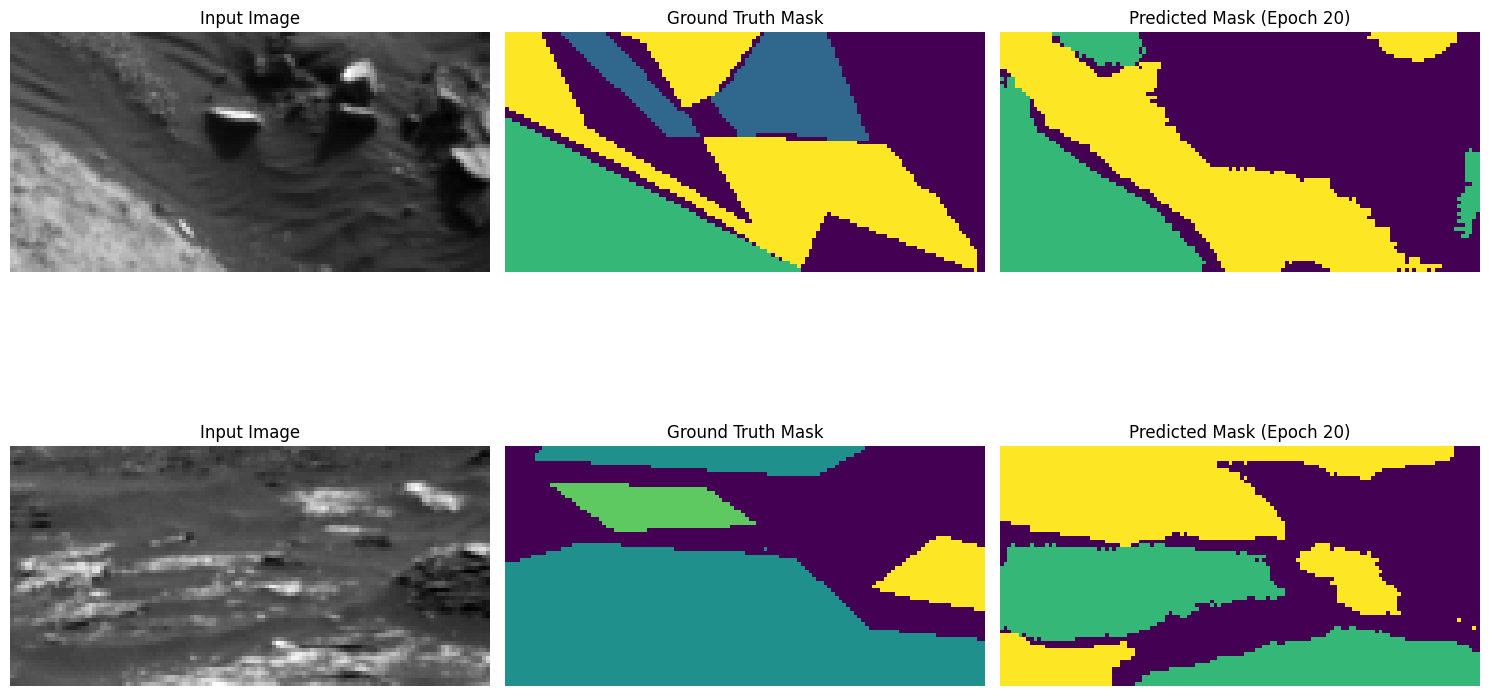

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 204ms/step - accuracy: 0.8524 - loss: 0.3876 - mean_io_u: 0.5384 - val_accuracy: 0.7618 - val_loss: 0.6659 - val_mean_io_u: 0.4489 - learning_rate: 1.0000e-04
Epoch 21/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8638 - loss: 0.3565 - mean_io_u: 0.5526
Epoch 21: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


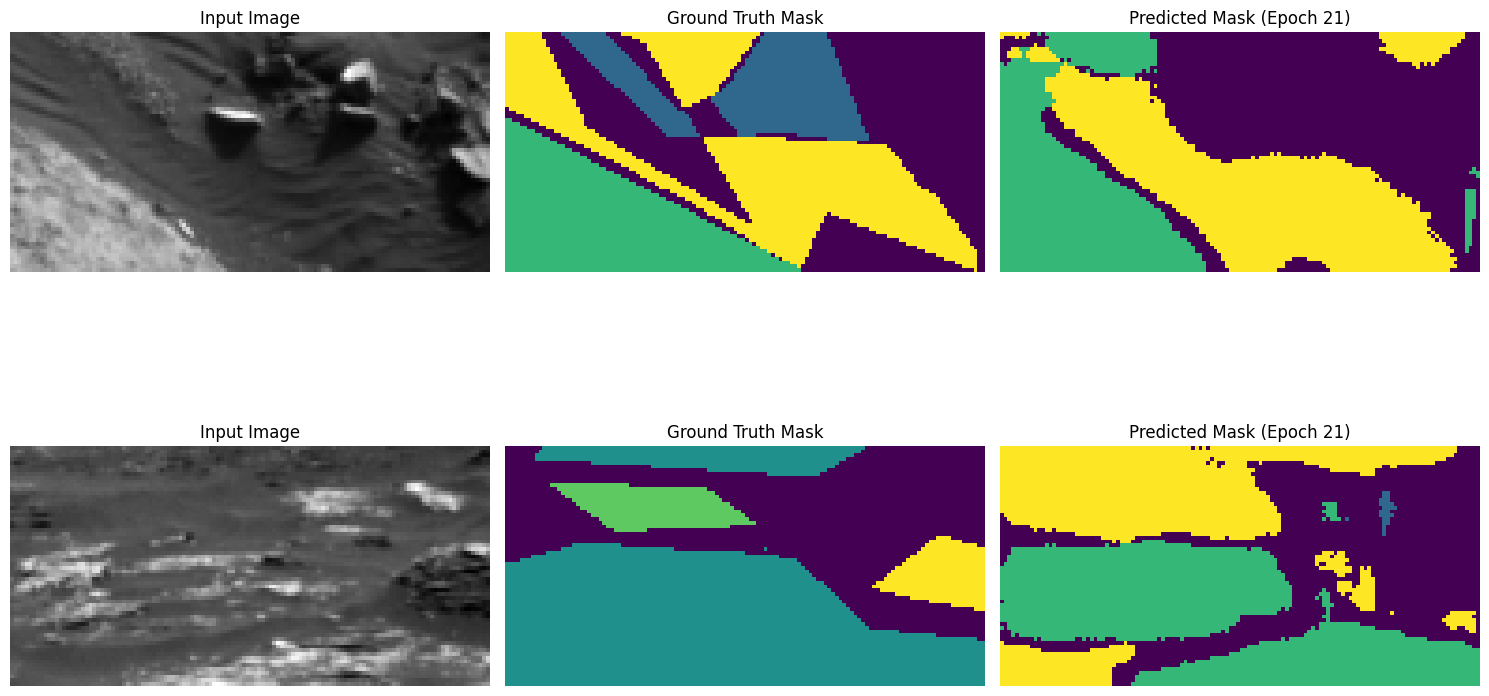

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 204ms/step - accuracy: 0.8638 - loss: 0.3565 - mean_io_u: 0.5525 - val_accuracy: 0.7674 - val_loss: 0.6836 - val_mean_io_u: 0.4541 - learning_rate: 5.0000e-05
Epoch 22/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8753 - loss: 0.3268 - mean_io_u: 0.5657
Epoch 22: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


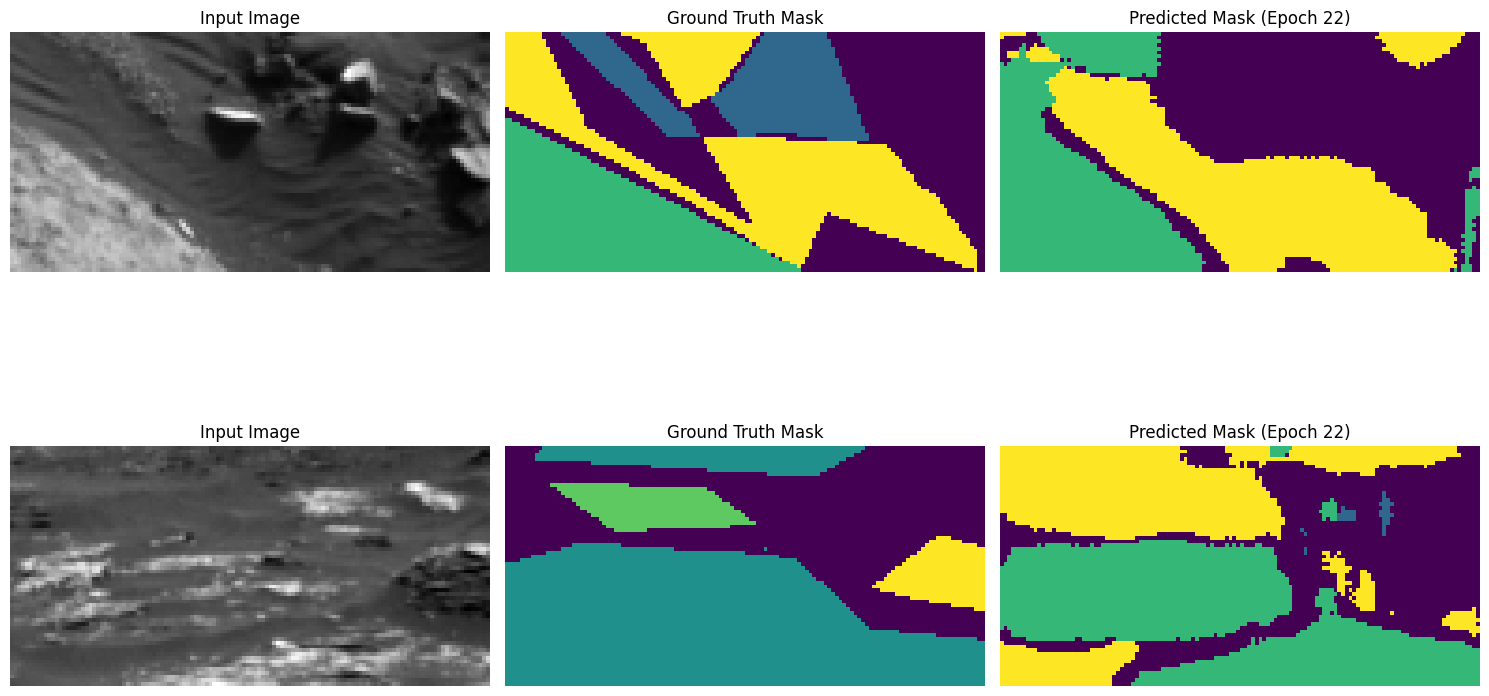

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 204ms/step - accuracy: 0.8753 - loss: 0.3268 - mean_io_u: 0.5657 - val_accuracy: 0.7647 - val_loss: 0.7045 - val_mean_io_u: 0.4516 - learning_rate: 5.0000e-05
Epoch 23/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8840 - loss: 0.3049 - mean_io_u: 0.5745
Epoch 23: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


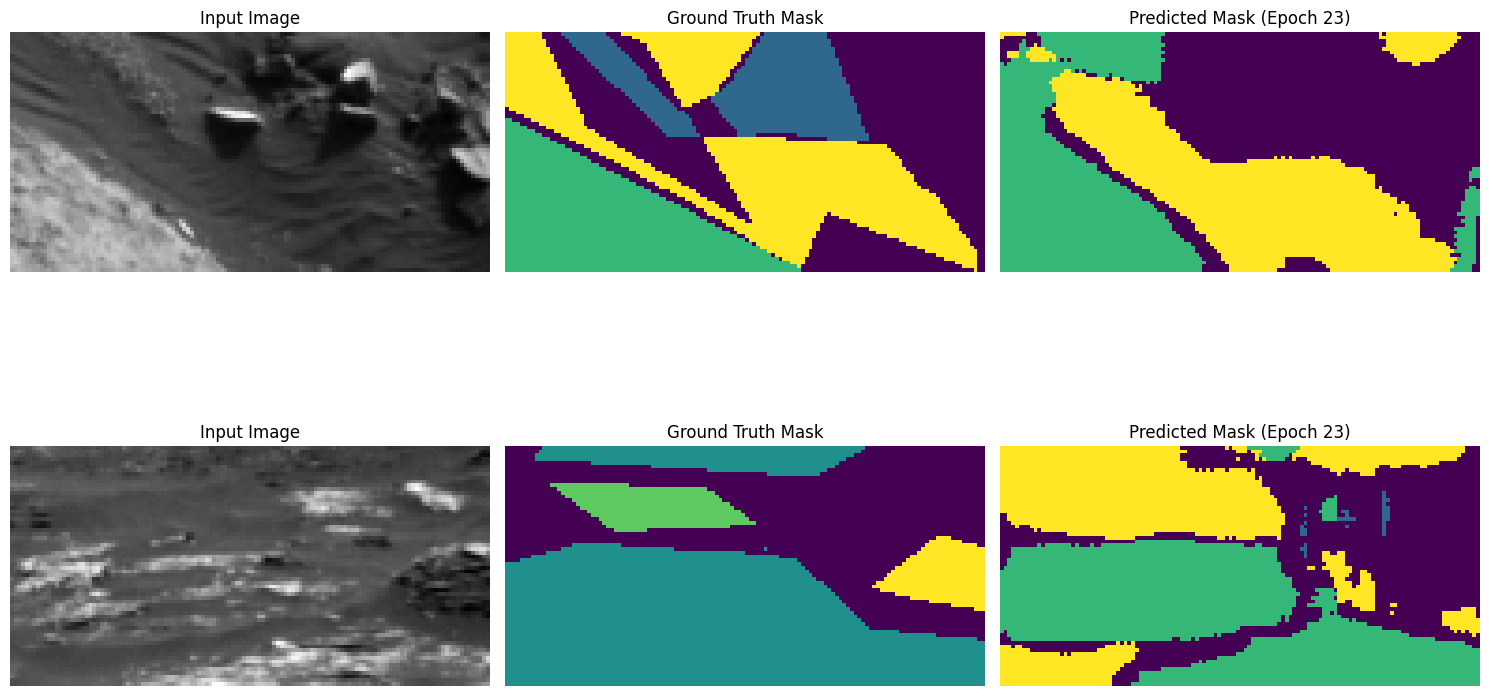

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 205ms/step - accuracy: 0.8840 - loss: 0.3049 - mean_io_u: 0.5745 - val_accuracy: 0.7629 - val_loss: 0.7300 - val_mean_io_u: 0.4501 - learning_rate: 5.0000e-05
Epoch 24/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8919 - loss: 0.2850 - mean_io_u: 0.5827
Epoch 24: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


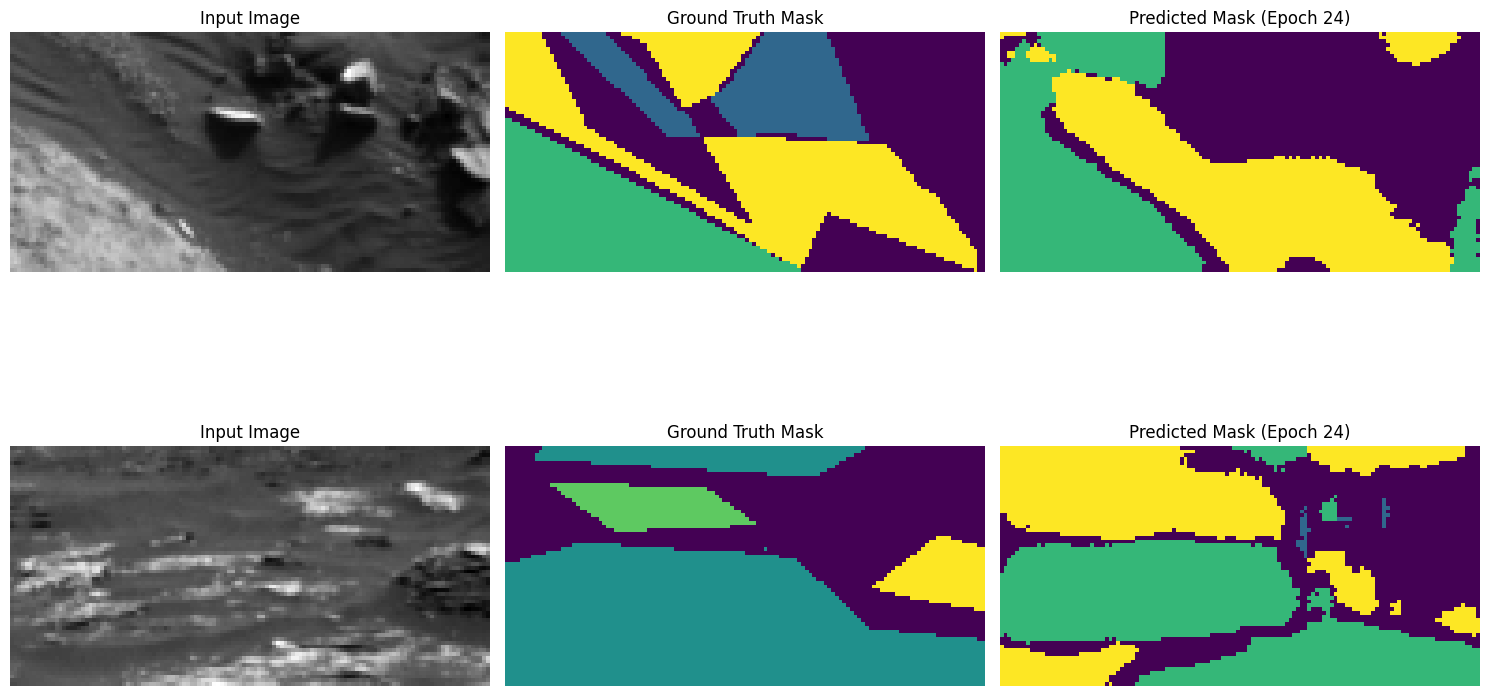

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 205ms/step - accuracy: 0.8919 - loss: 0.2850 - mean_io_u: 0.5827 - val_accuracy: 0.7625 - val_loss: 0.7572 - val_mean_io_u: 0.4506 - learning_rate: 5.0000e-05
Epoch 25/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8993 - loss: 0.2664 - mean_io_u: 0.5911
Epoch 25: val_loss did not improve from 0.62921

Epoch 25: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


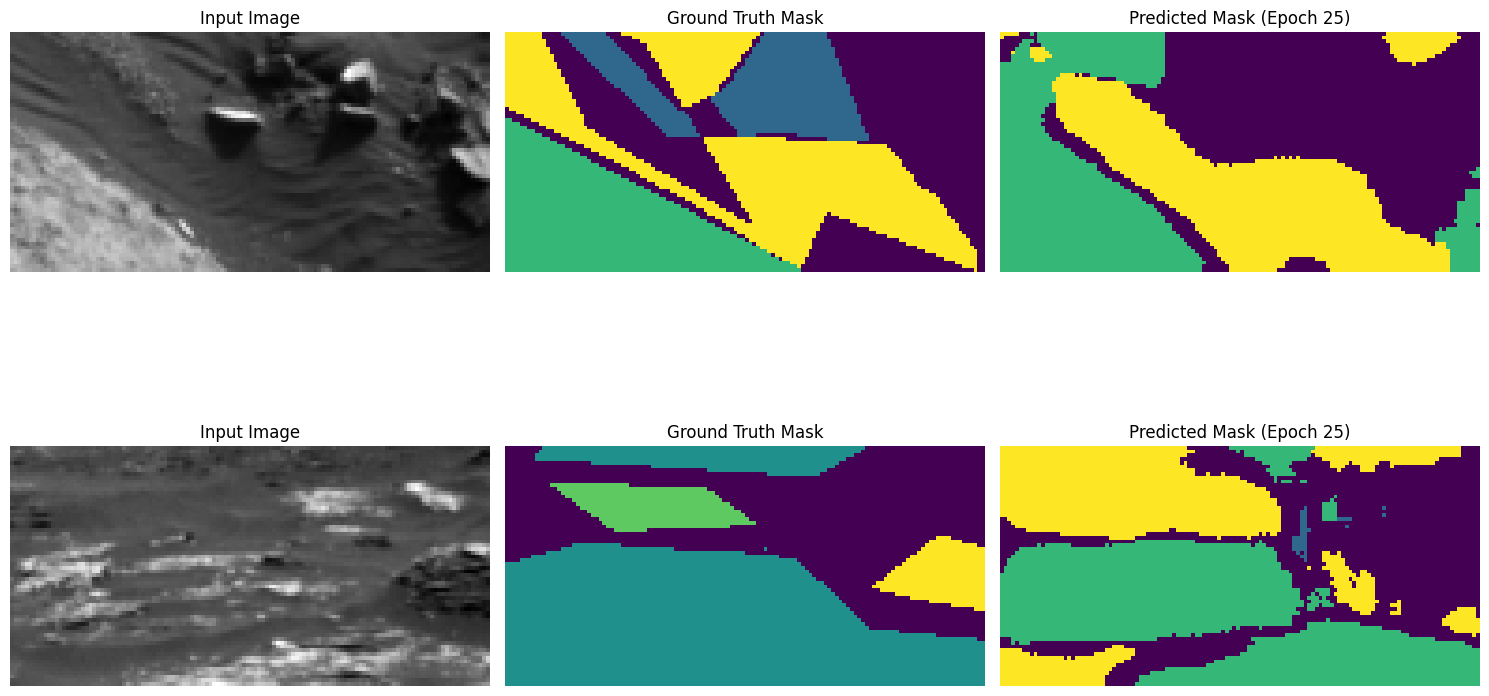

439/439 ━━━━━━━━━━━━━━━━━━━━ 141s 203ms/step - accuracy: 0.8993 - loss: 0.2664 - mean_io_u: 0.5910 - val_accuracy: 0.7625 - val_loss: 0.7911 - val_mean_io_u: 0.4515 - learning_rate: 5.0000e-05
Epoch 26/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9034 - loss: 0.2546 - mean_io_u: 0.5966
Epoch 26: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


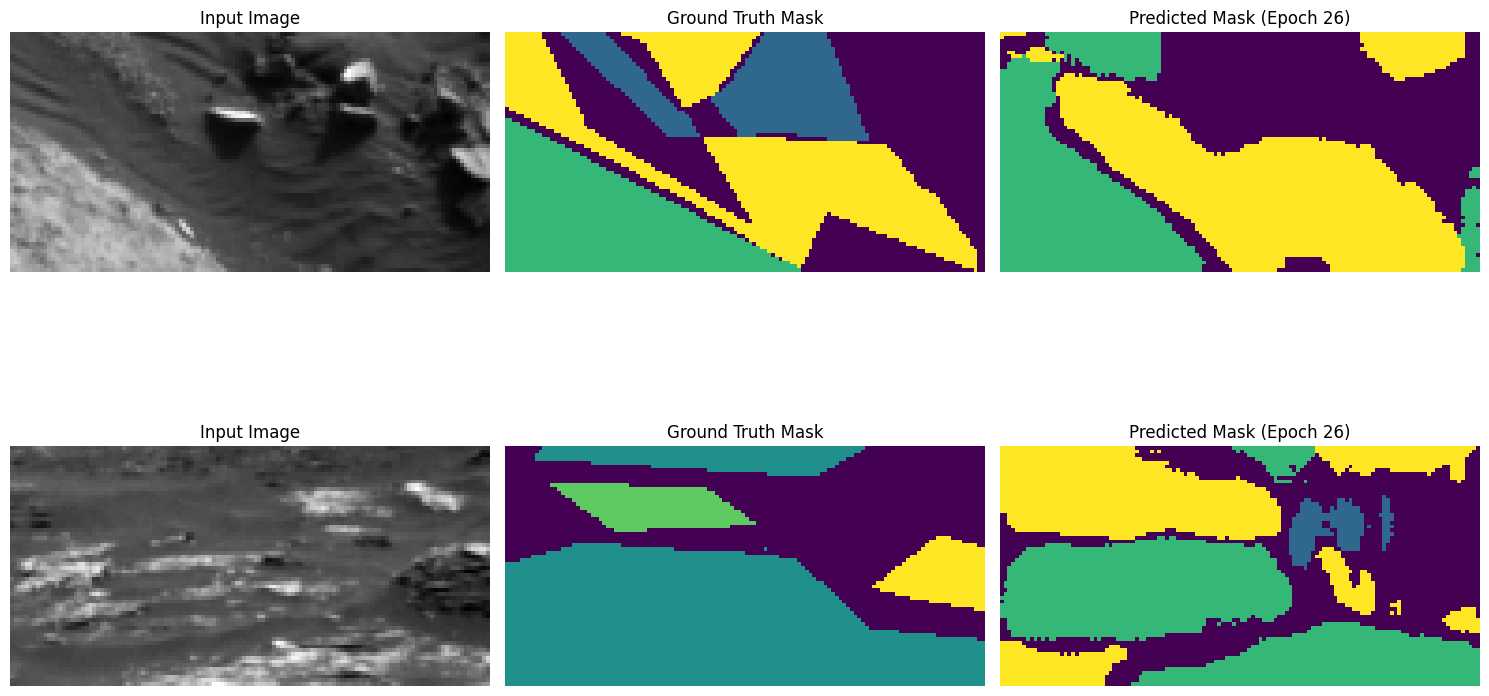

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 203ms/step - accuracy: 0.9034 - loss: 0.2546 - mean_io_u: 0.5966 - val_accuracy: 0.7628 - val_loss: 0.8031 - val_mean_io_u: 0.4534 - learning_rate: 2.5000e-05
Epoch 27/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9096 - loss: 0.2391 - mean_io_u: 0.6038
Epoch 27: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


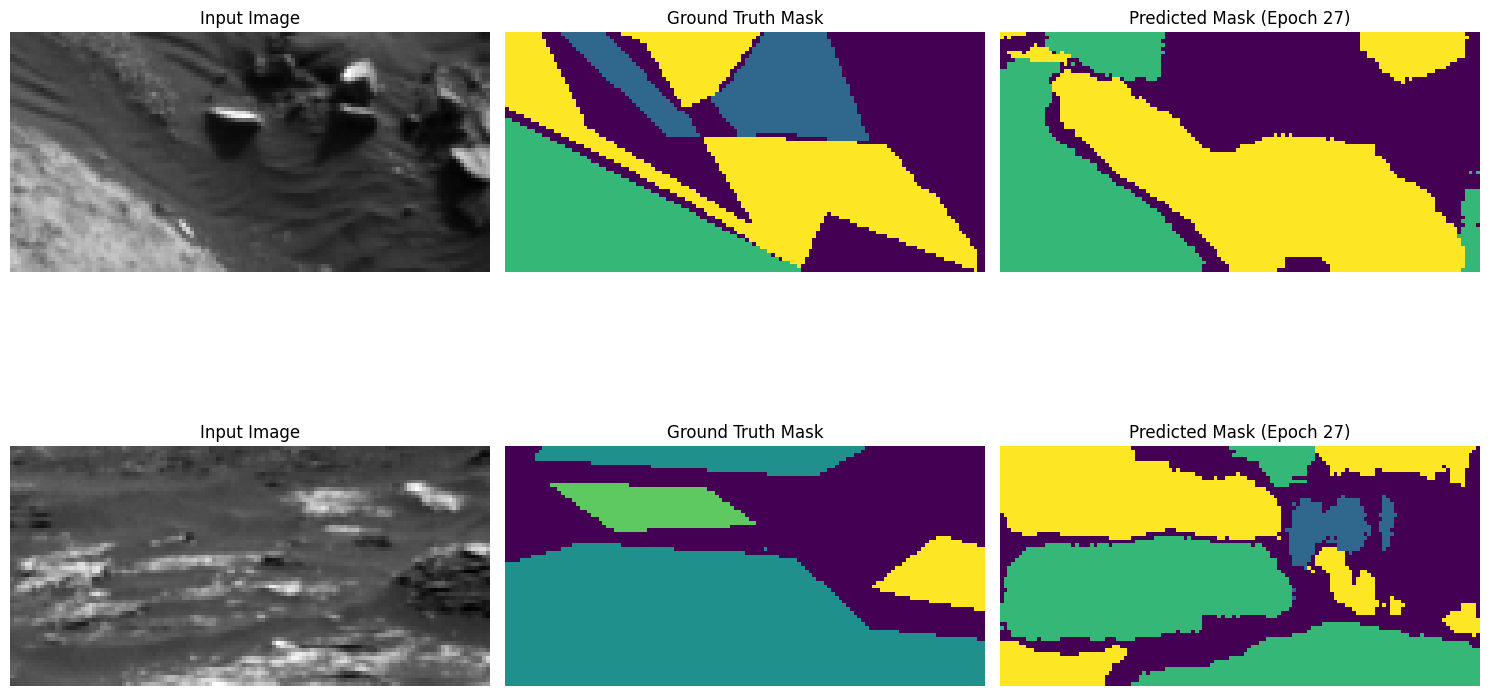

439/439 ━━━━━━━━━━━━━━━━━━━━ 90s 205ms/step - accuracy: 0.9096 - loss: 0.2391 - mean_io_u: 0.6038 - val_accuracy: 0.7625 - val_loss: 0.8259 - val_mean_io_u: 0.4549 - learning_rate: 2.5000e-05
Epoch 28/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9152 - loss: 0.2255 - mean_io_u: 0.6103
Epoch 28: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


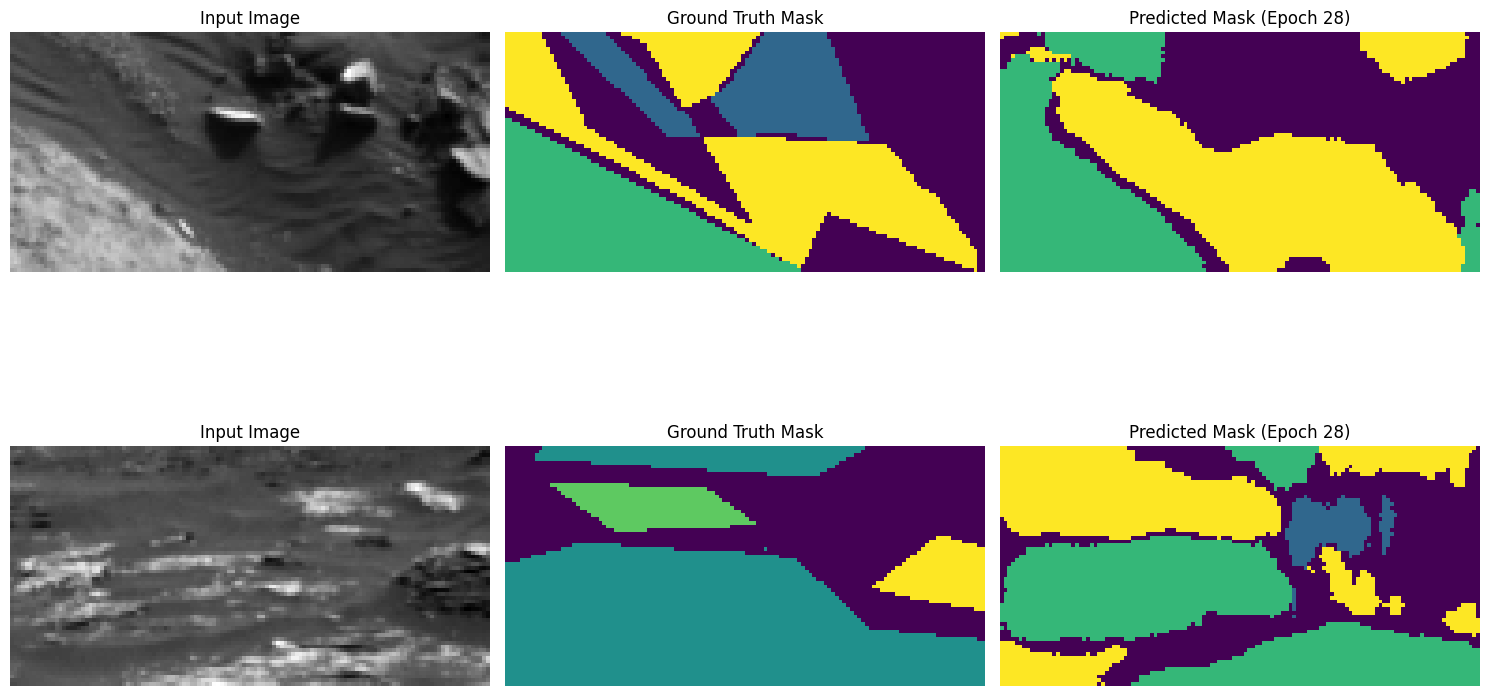

439/439 ━━━━━━━━━━━━━━━━━━━━ 141s 203ms/step - accuracy: 0.9152 - loss: 0.2255 - mean_io_u: 0.6103 - val_accuracy: 0.7618 - val_loss: 0.8531 - val_mean_io_u: 0.4548 - learning_rate: 2.5000e-05
Epoch 29/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9201 - loss: 0.2133 - mean_io_u: 0.6158
Epoch 29: val_loss did not improve from 0.62921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


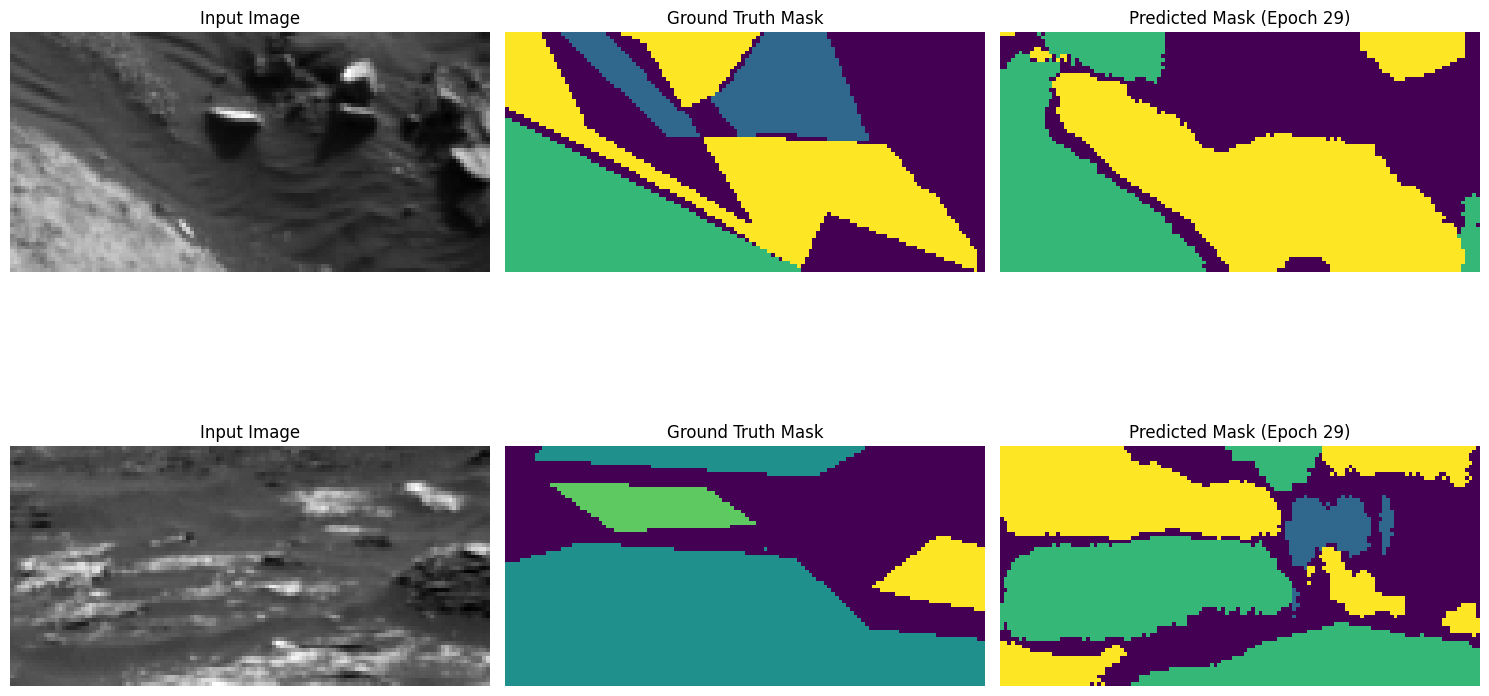

439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 203ms/step - accuracy: 0.9201 - loss: 0.2133 - mean_io_u: 0.6158 - val_accuracy: 0.7608 - val_loss: 0.8807 - val_mean_io_u: 0.4543 - learning_rate: 2.5000e-05
Epoch 30/1000
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9246 - loss: 0.2021 - mean_io_u: 0.6208
Epoch 30: val_loss did not improve from 0.62921

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


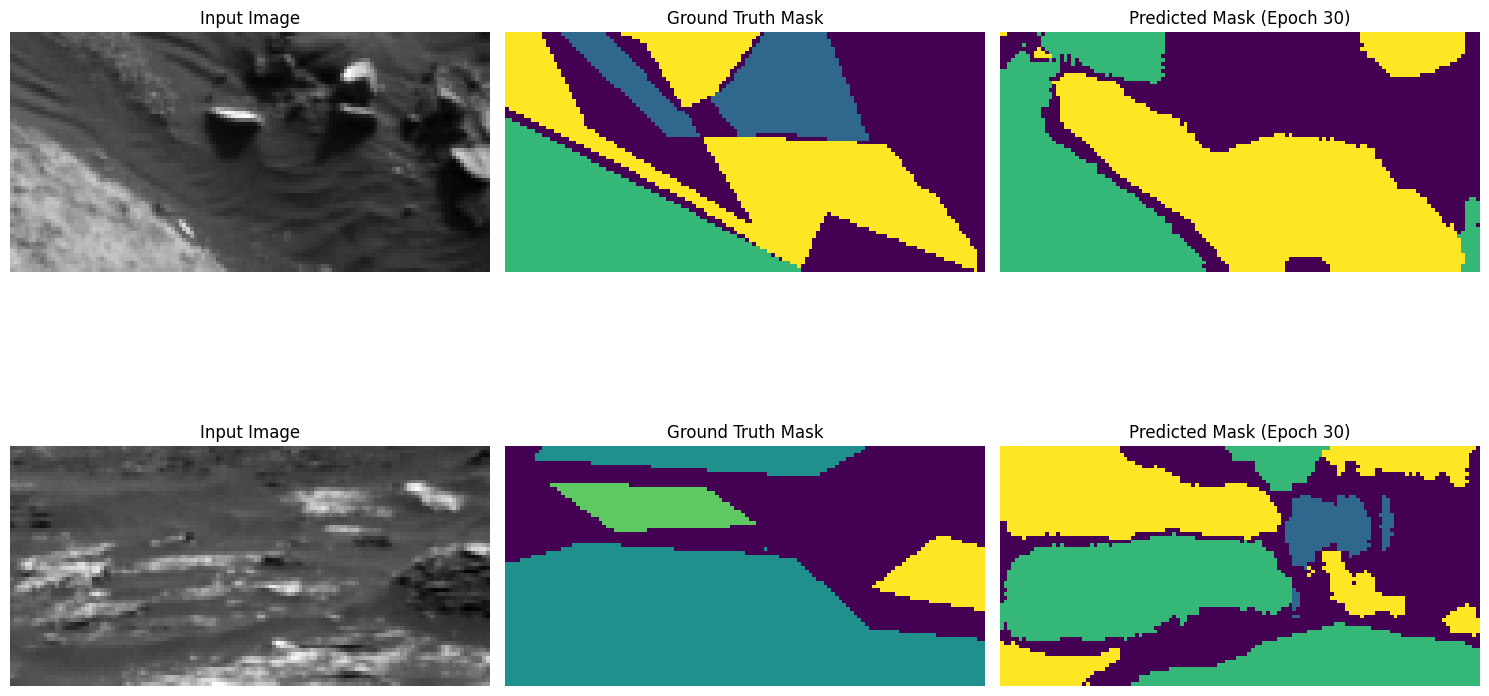

439/439 ━━━━━━━━━━━━━━━━━━━━ 143s 205ms/step - accuracy: 0.9246 - loss: 0.2021 - mean_io_u: 0.6208 - val_accuracy: 0.7597 - val_loss: 0.9116 - val_mean_io_u: 0.4537 - learning_rate: 2.5000e-05


In [39]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model = unet_with_residual_blocks(input_shape, num_classes)
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy", mean_iou])

model.summary()

# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    epochs=1000,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)

# Save the model
model.save("best_model_resunet.keras")


In [40]:
model_filename = f"model_augmented_hvr_and_randoms_best.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_augmented_hvr_and_randoms_best.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [41]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [42]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [43]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


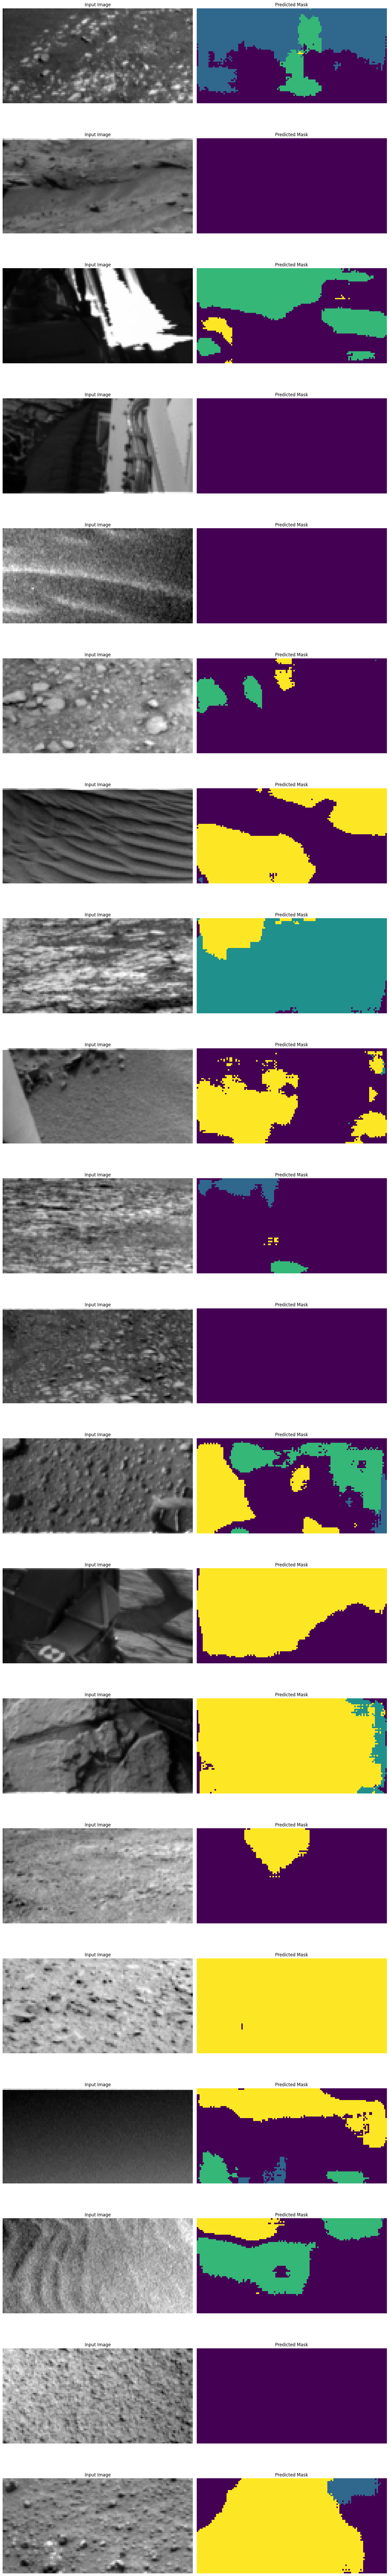

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [45]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [46]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [47]:
len(submission_df.columns)

8193

In [48]:
len(submission_df)

10022